# Marmousi Model

In [1]:
from pathlib import Path
EXP_PATH = Path()
print("Working Directory:", str(EXP_PATH))
SRC_PATH = Path("../") / "src"
print("Source Code Path:", str(SRC_PATH))
import sys
sys.path.insert(0, str(SRC_PATH))

Working Directory: .
Source Code Path: ../src


In [2]:
import numpy as np
from utils.problems import (
    SesimicInverseProblemWithJuliaWaveSimulation,
    SeismicInverseProblem,
)
from utils.wave_modeling_julia import WaveModeling

client = WaveModeling("/tmp/mathew-seismic", timeout=120)
sip = SesimicInverseProblemWithJuliaWaveSimulation(
    Lx=9200.0,
    Ly=2400.0,
    nx=461,
    ny=121,
    cmin=1500.0,
    cmax=4000.0,
    smooth_sigma=6,
    mt=np.load("mt.npy"),
    fmin=4.0,
    fmax=10.0,
    n_src=92,
    n_rcv=153,
    T=8.0,
    nt=4001,
    window_config={
        "left": 30,
        "right": 30,
        "up": 20,
        "down": 20,
        "ex": 3.0,
        "ll": 2.0,
    },
    prior_config={"name": "bilaplacian", "sigma2": 300.0},
    noise_variance=0.01,
    plot_config={
        "rcParams": {
            "image.cmap": "bwr",
        },
        "x_size": [7, 2],
        "f_size": [2.4, 2],
    },
    label="marmousi",
    path=EXP_PATH,
    client=client,
)

In [3]:
# Fix water layer
xf: np.ndarray = np.load("xf.npy")
xf = np.hstack([np.zeros((461,20)), xf.reshape(461,101)])
xf = sip.W @ xf.flatten()
H = sip.misfit_hess(xf)  # Hessian at MAP point

## Hessian approximations

### The PSF Method

/storage/mathew/GitHub/lrs-psido/marmousi_model_uq/../src/lrs_psido/plot.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(


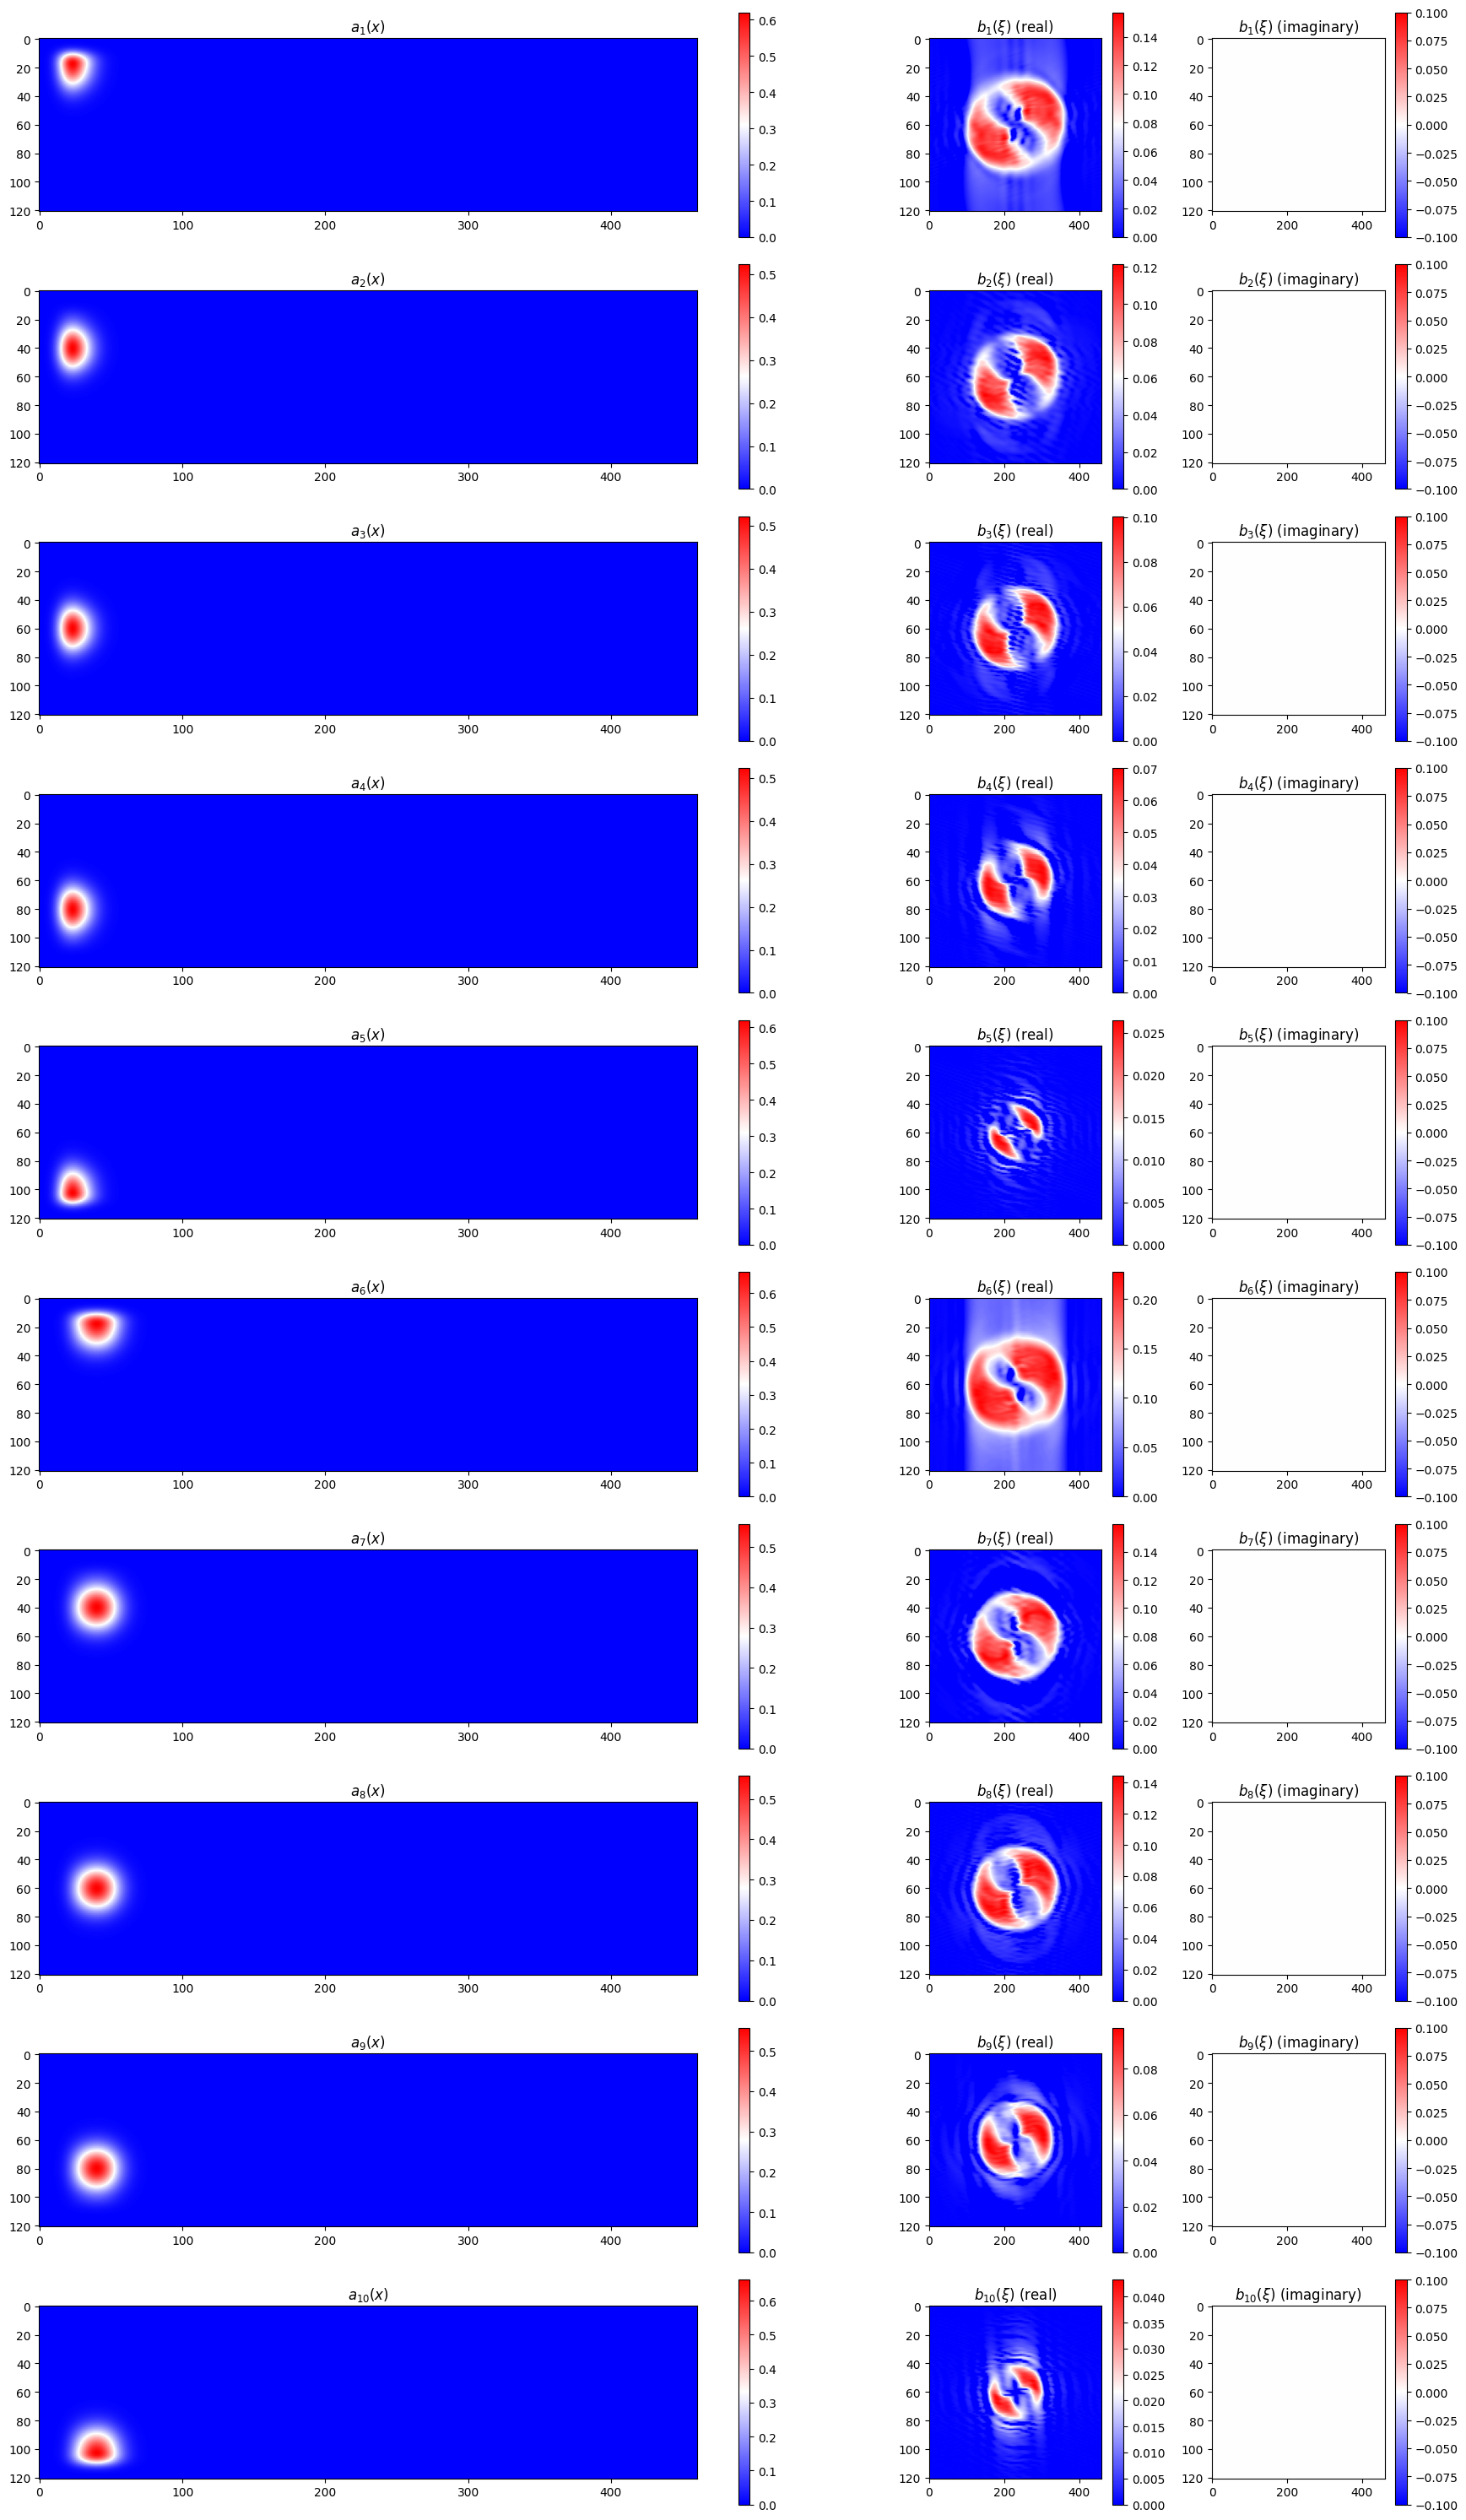

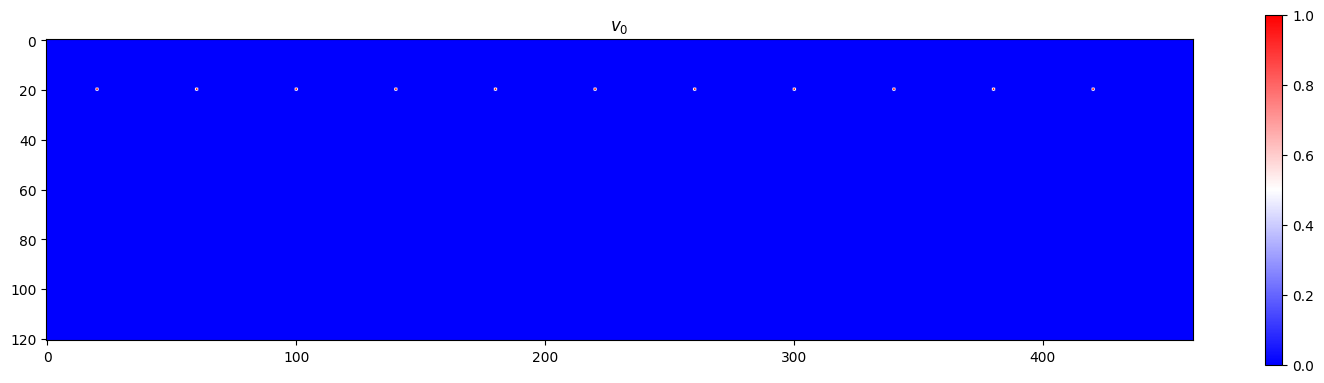

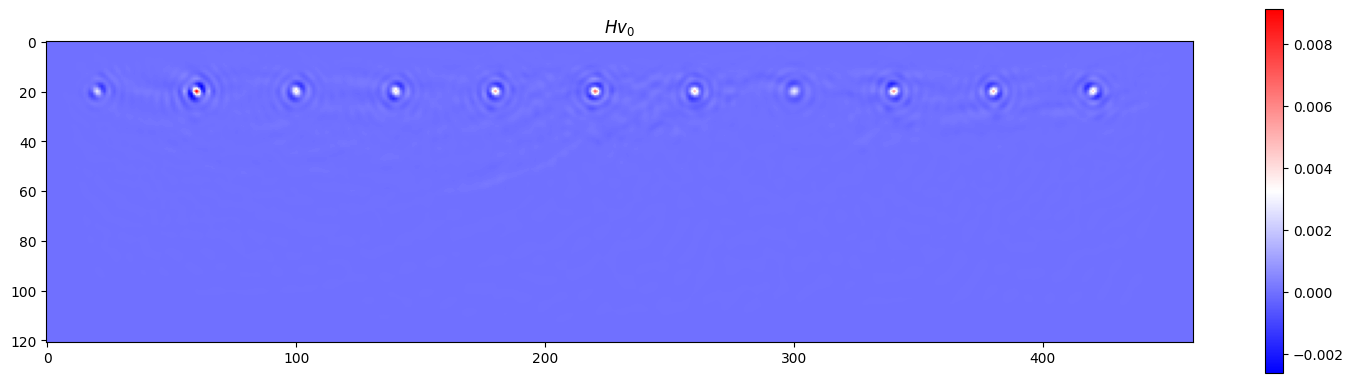

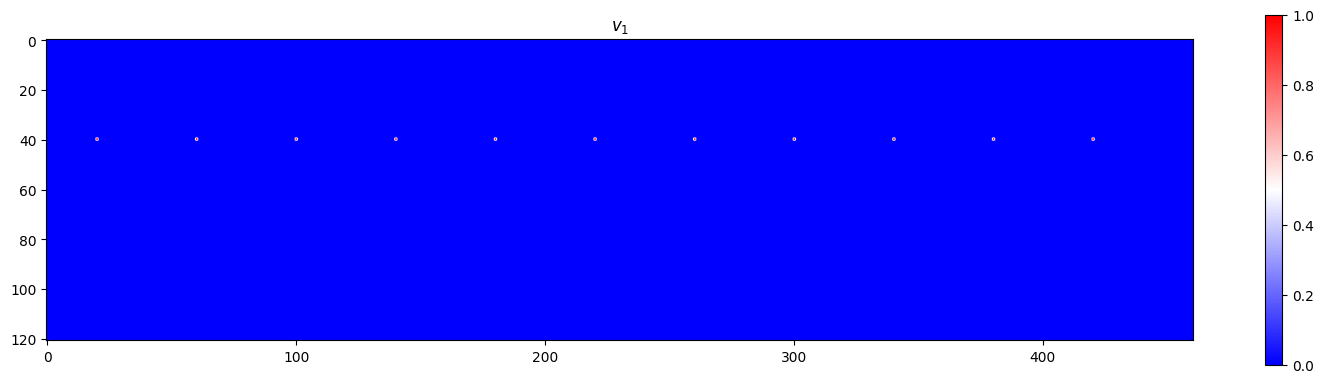

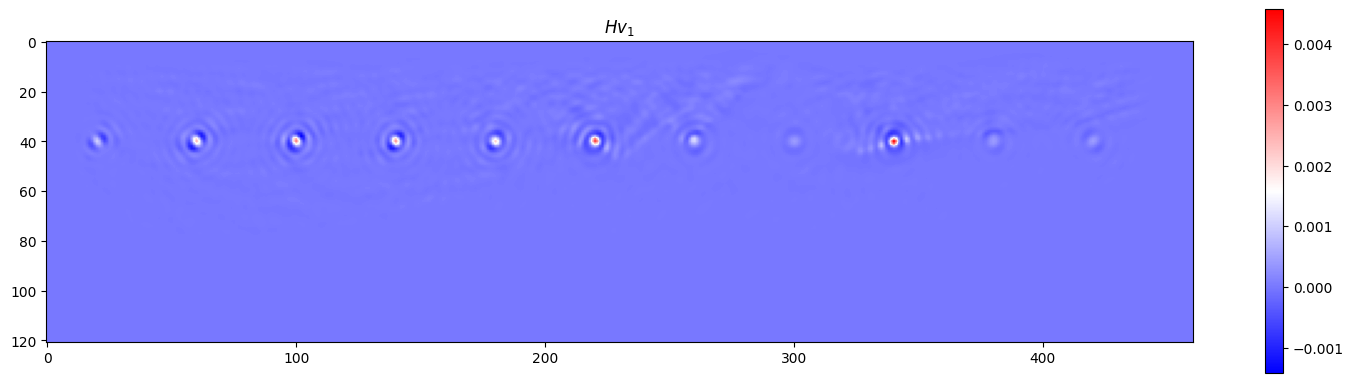

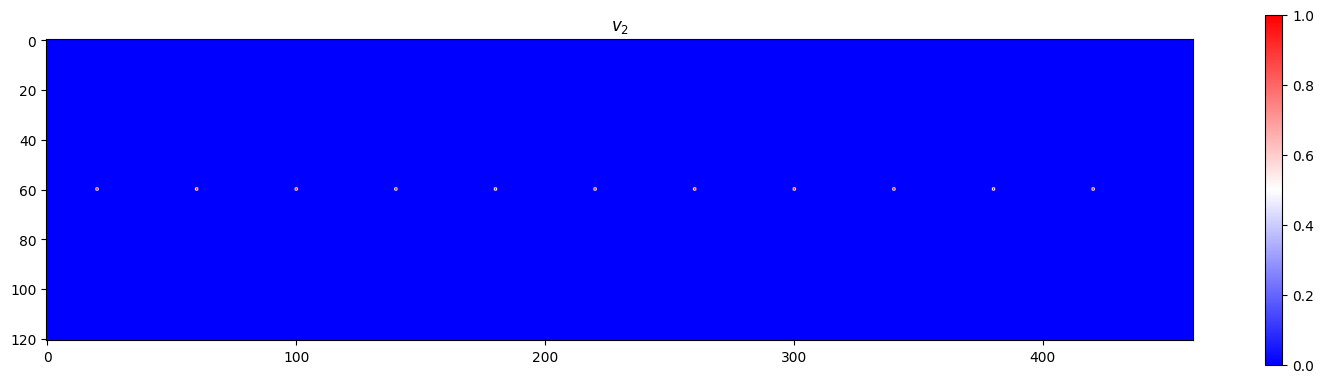

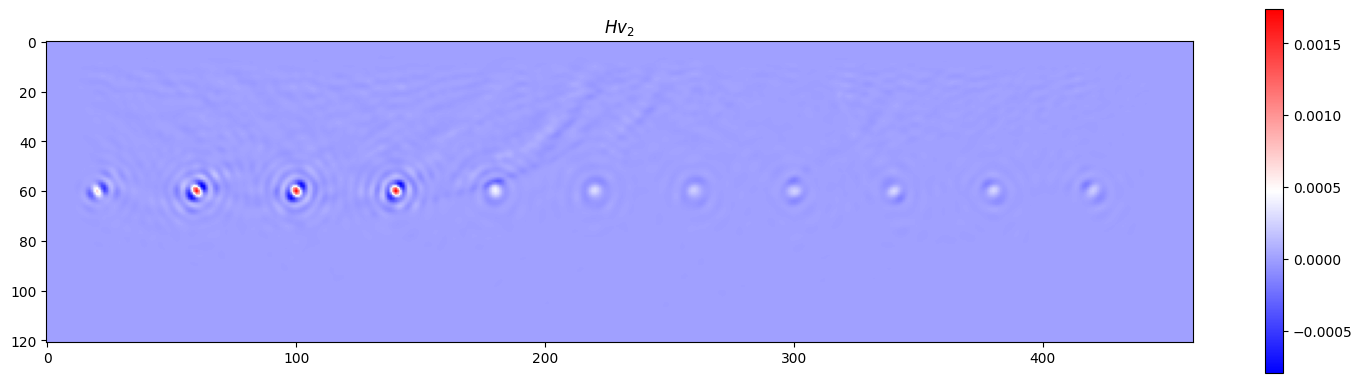

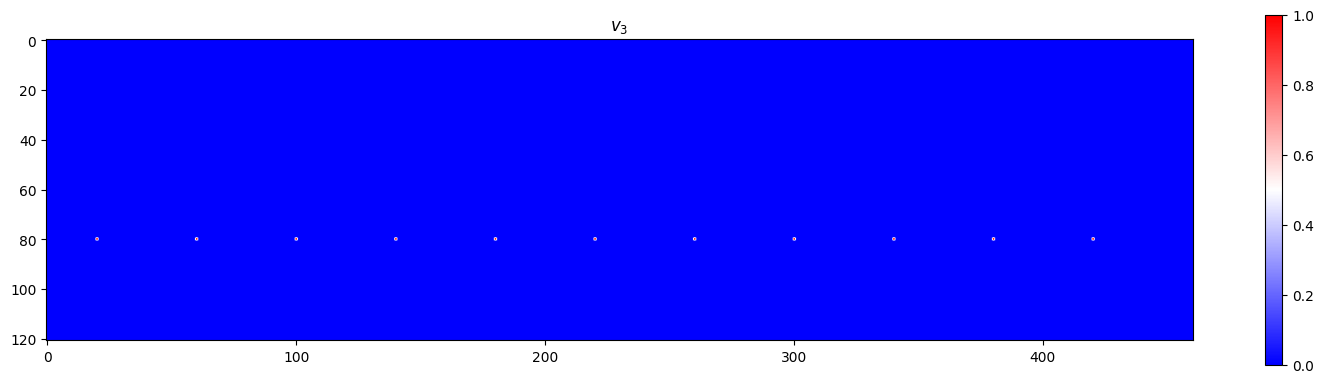

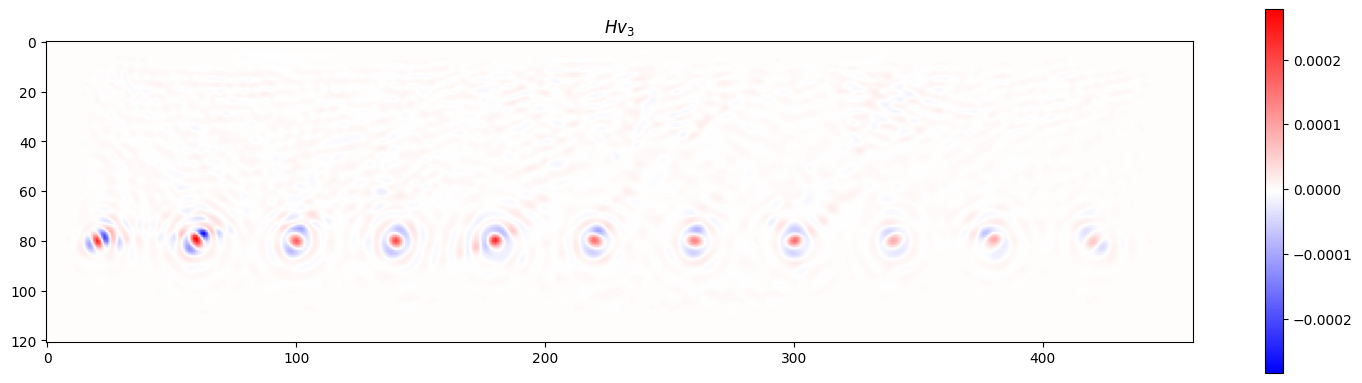

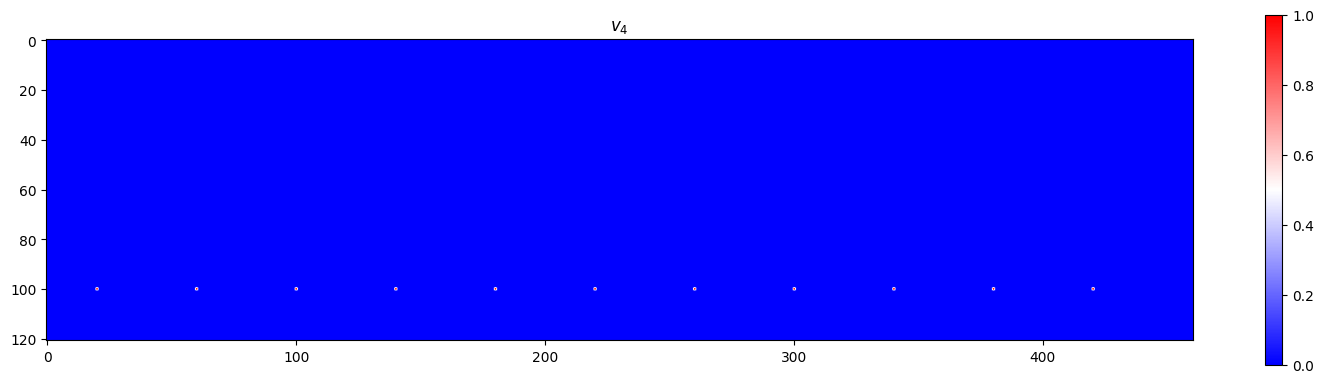

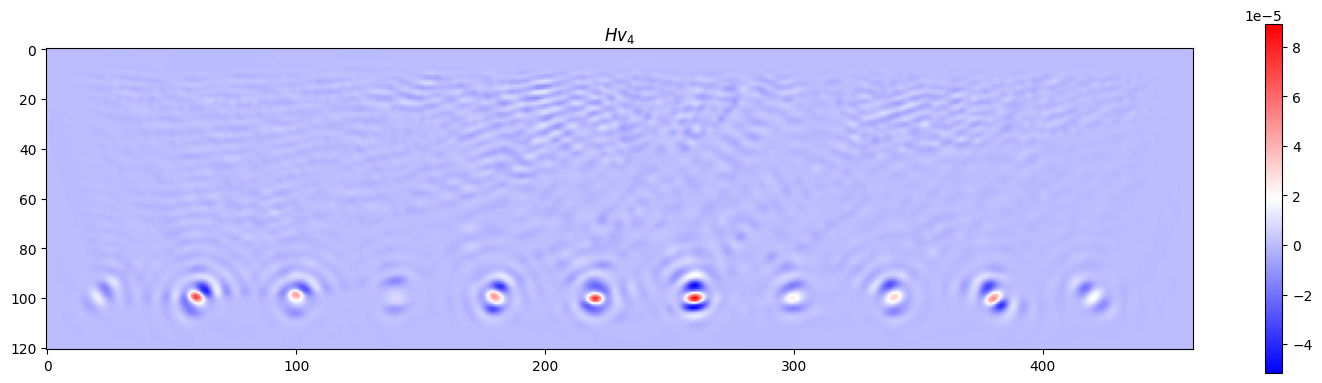

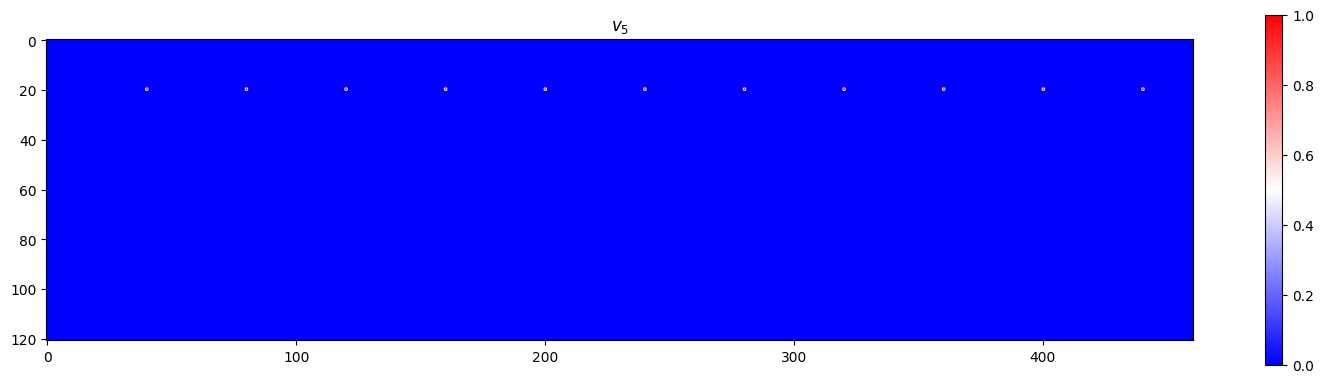

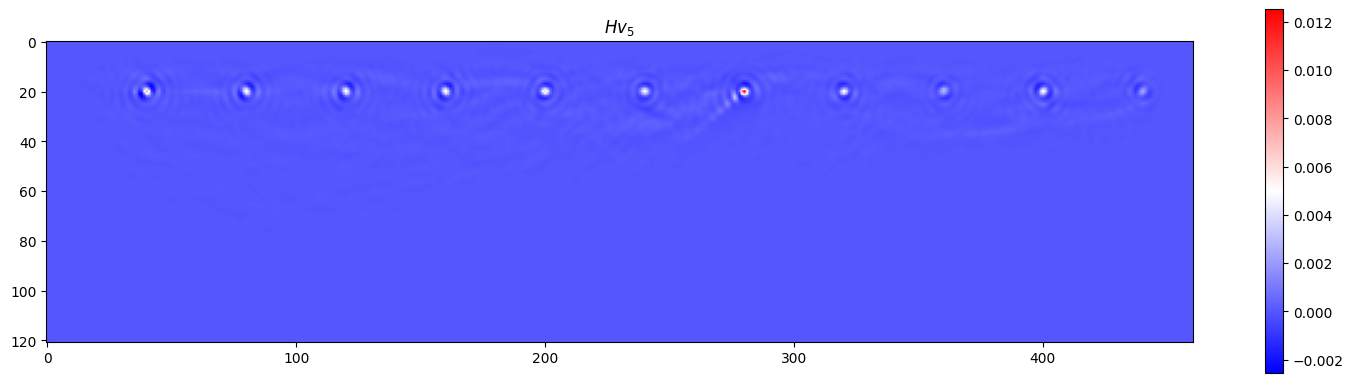

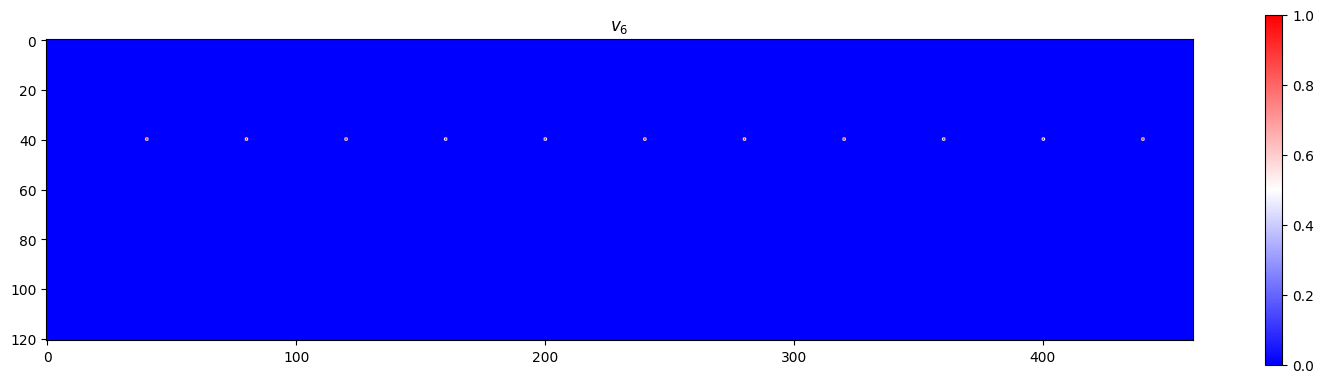

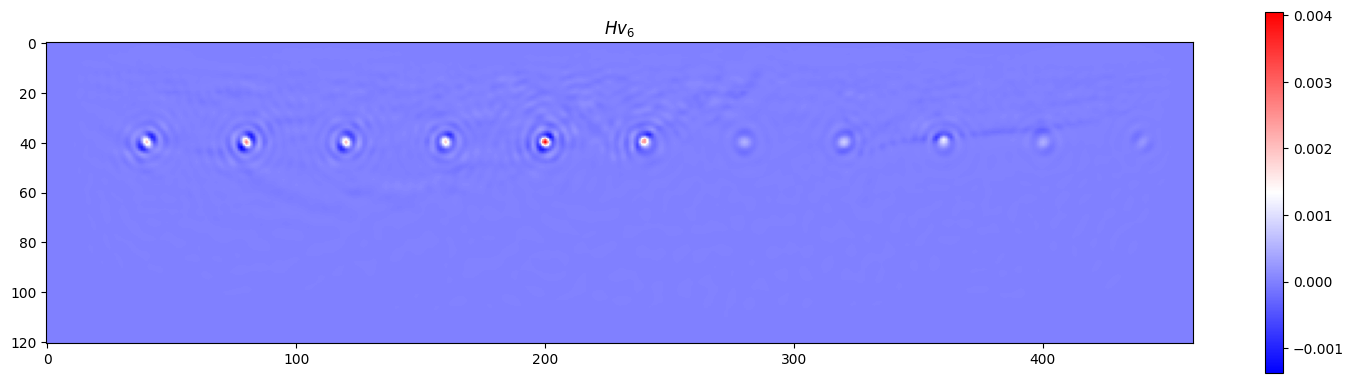

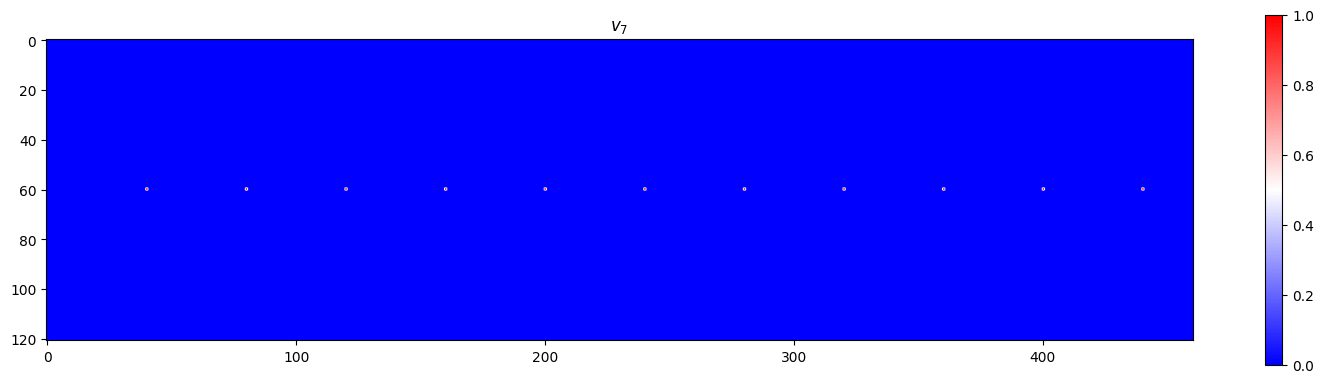

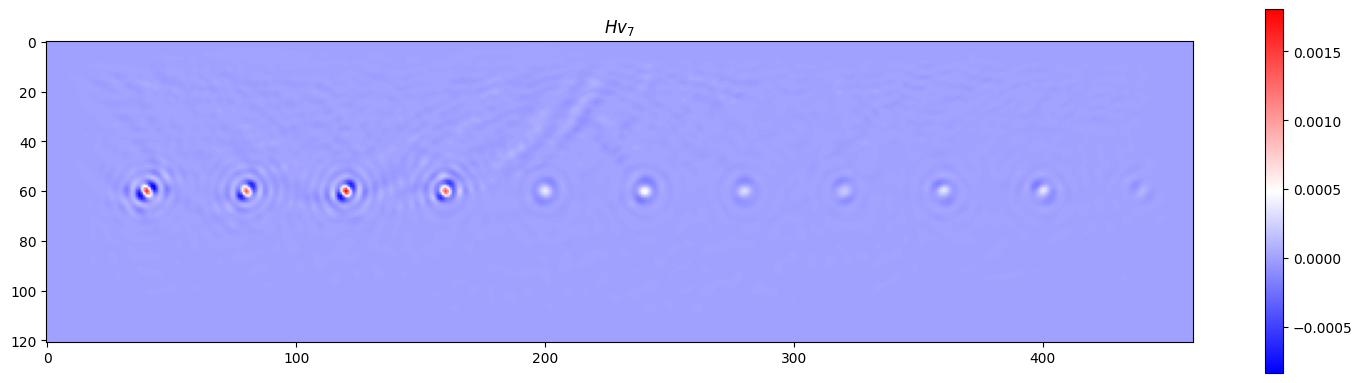

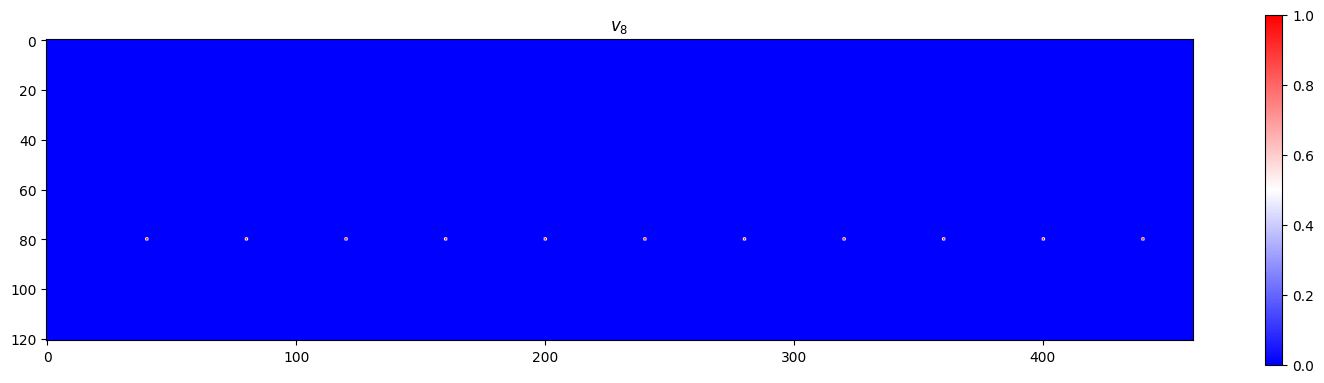

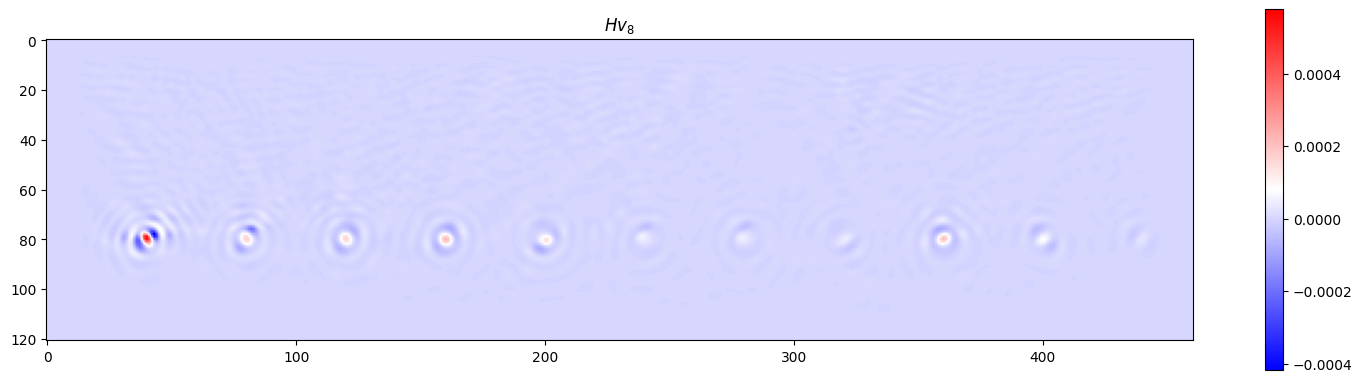

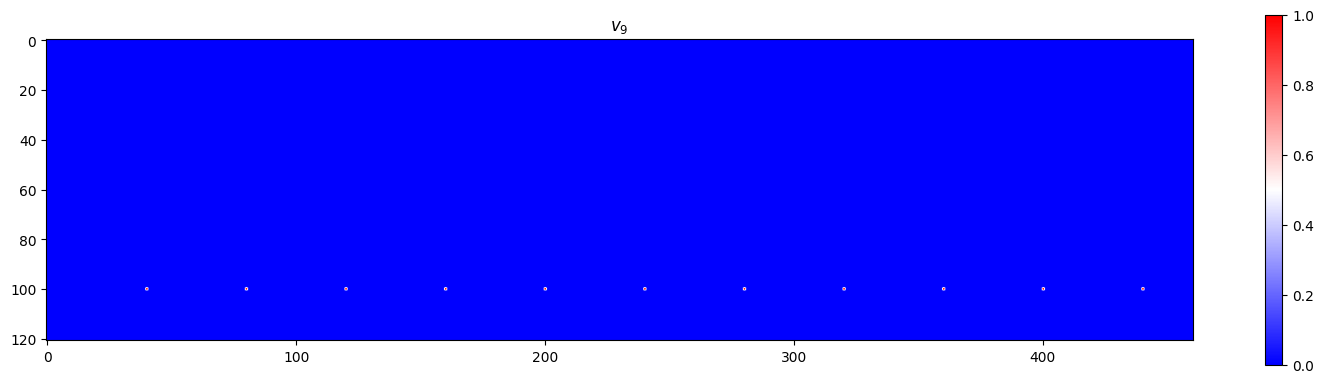

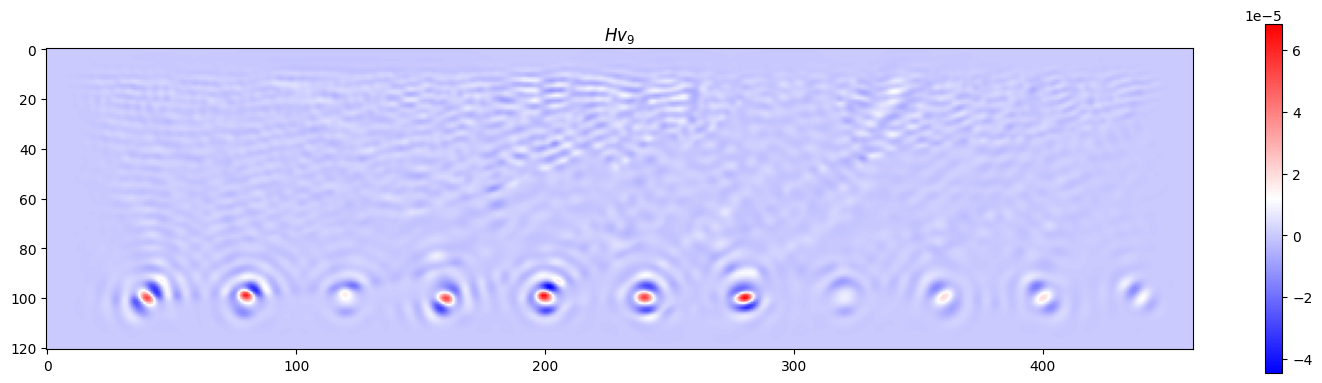

In [4]:
from lrs_psido.approximators import PsfApproximator

psf_settings = {
    "filter_sigma": 4.0,
    "matvec_plan": [
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [20, 20],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [20, 40],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [20, 60],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [20, 80],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [20, 100],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [40, 20],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [40, 40],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [40, 60],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [40, 80],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 120],
                "anchor": [40, 100],
                "constraint": {"x": [20, 440], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
    ],
    "smooth": False,
    "real_only": True,
    "sqrt": True,
}
psf_approximator = PsfApproximator(
    sip.n, log_dir=EXP_PATH / "psf", window=sip.window, show_proc=False, **psf_settings
)
psf_sqrtH = psf_approximator.approximate_sqrt(H)

### The PDO Method

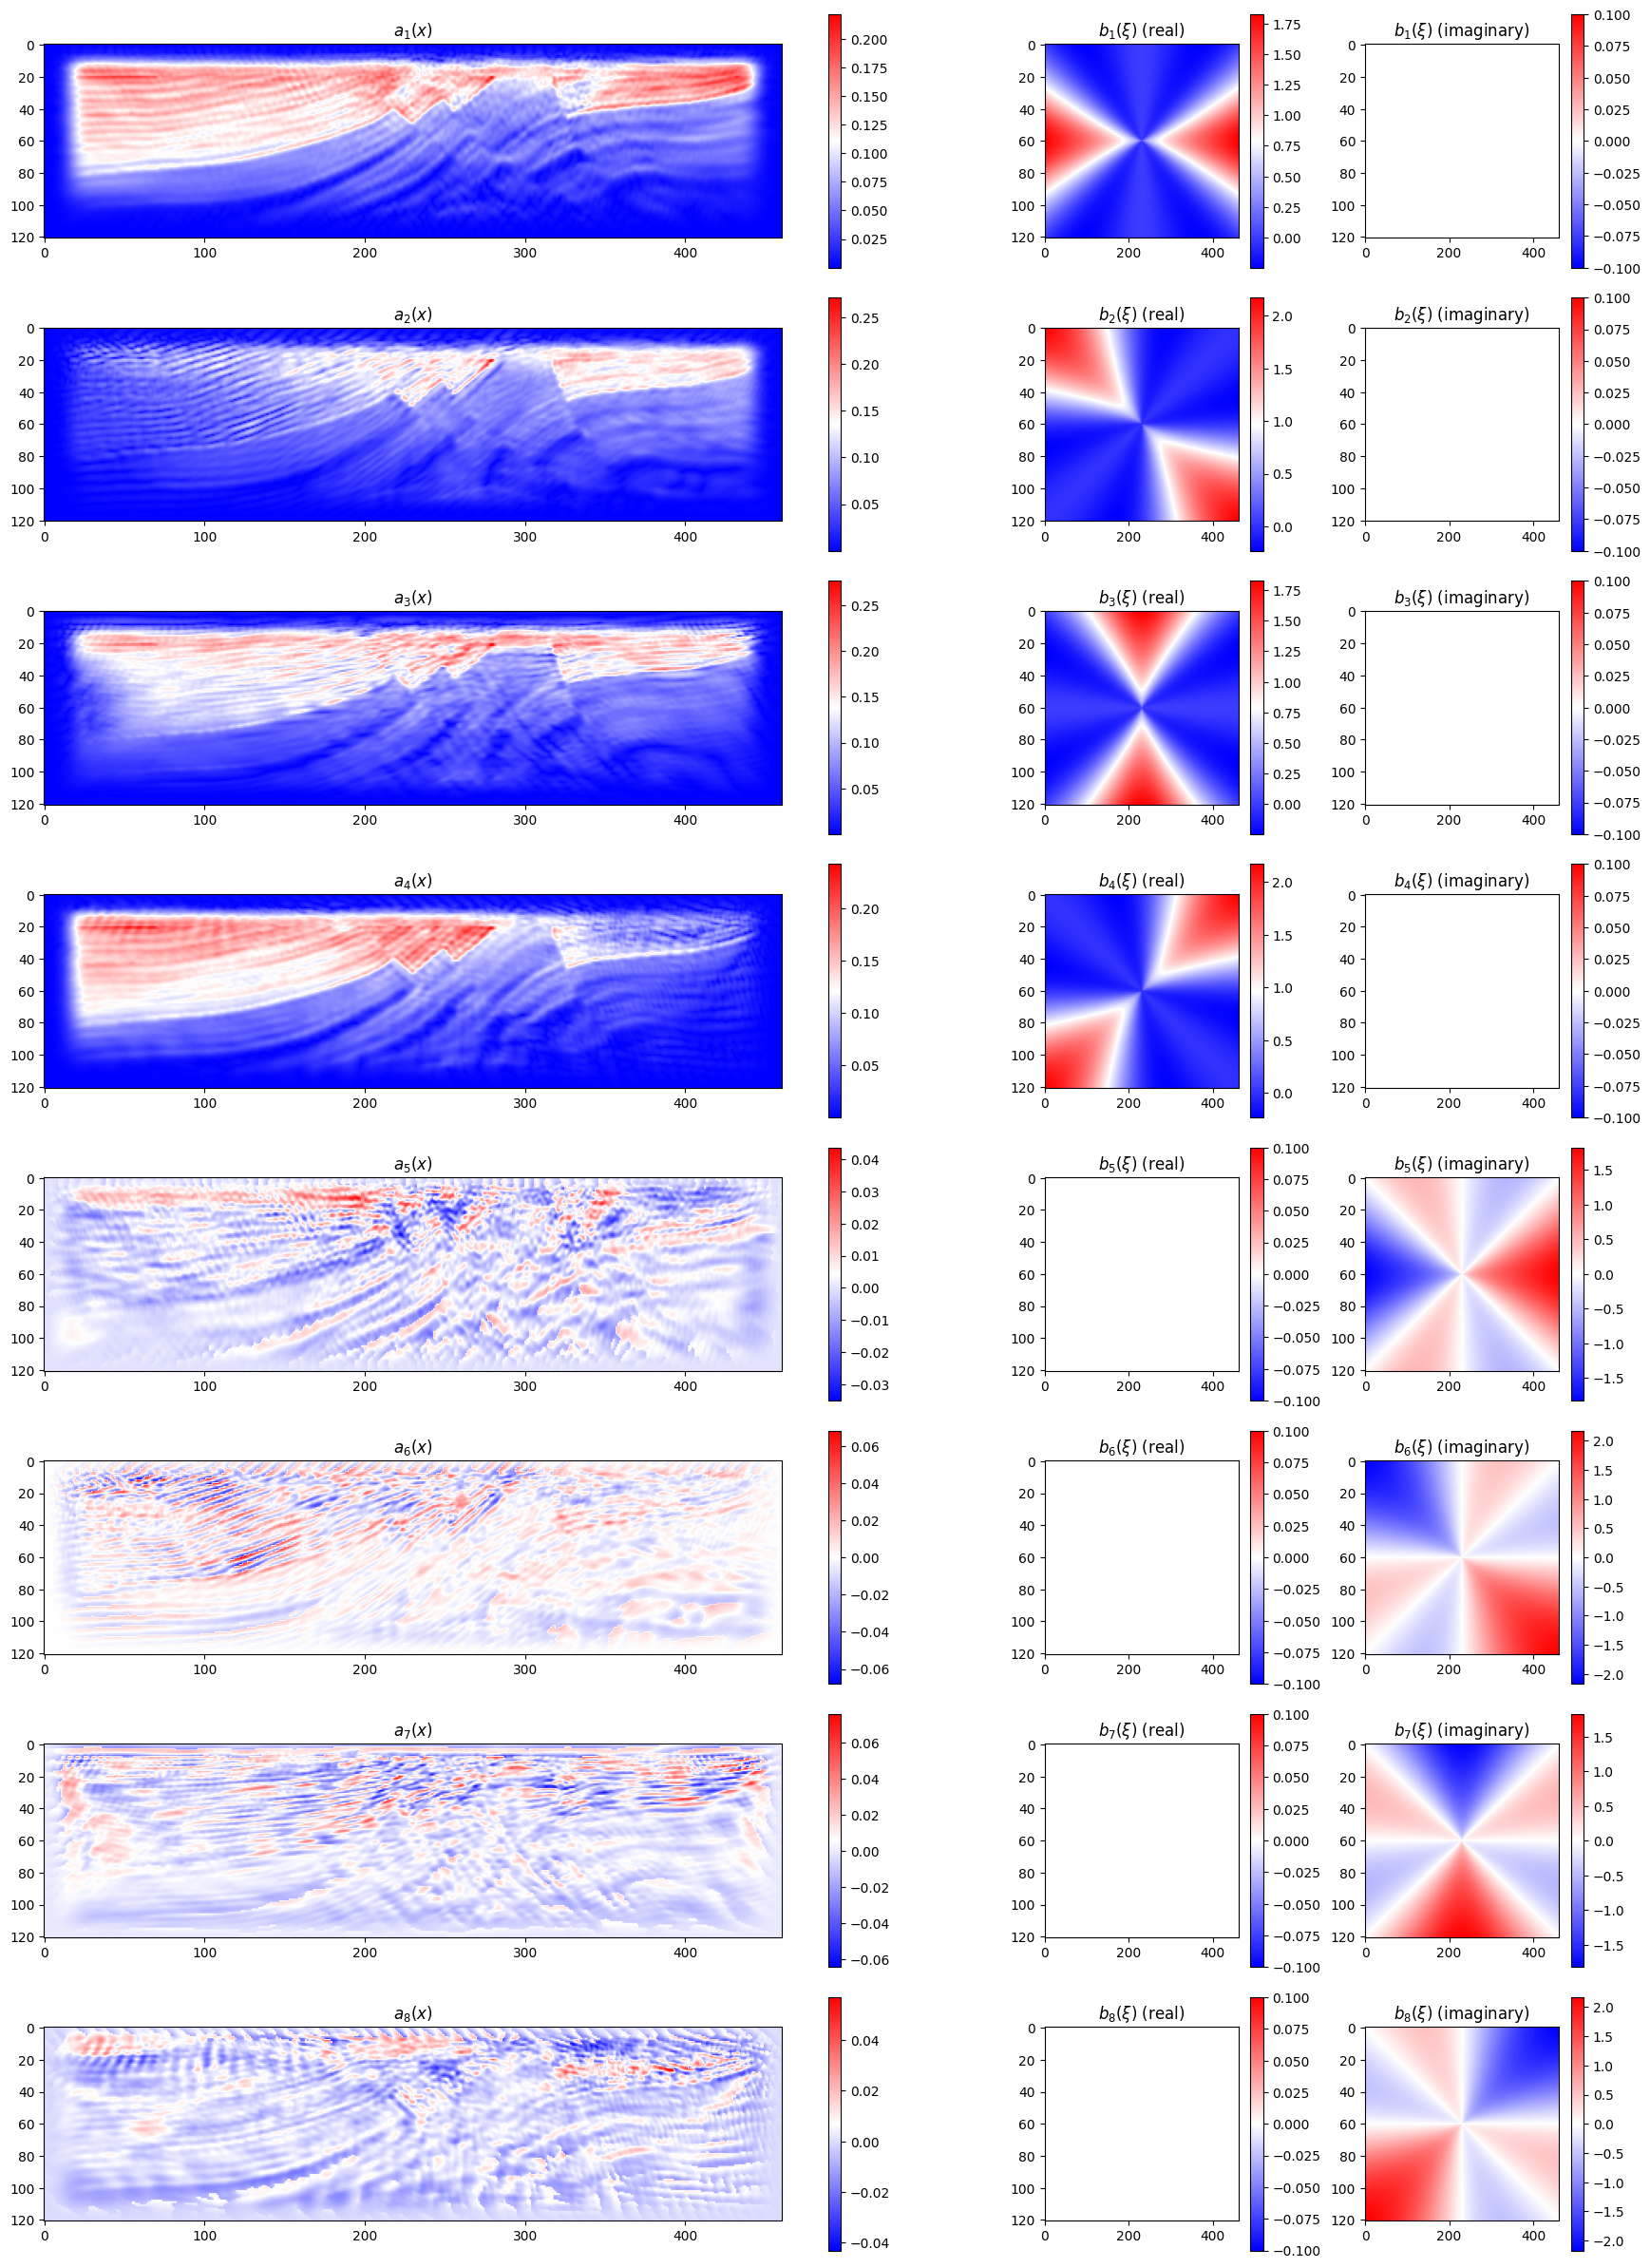

In [4]:
from lrs_psido.approximators import PdoApproximator

pdo_settings = {
    "filter_sigma": 4.0,
    "matvec_plan": [
        {"sampling": {"method": "custom", "indices": [[69, 0]]}},
        {"sampling": {"method": "custom", "indices": [[49, 13]]}},
        {"sampling": {"method": "custom", "indices": [[0, 18]]}},
        {"sampling": {"method": "custom", "indices": [[412, 13]]}},
        {"sampling": {"method": "custom", "indices": [[392, 0]]}},
        {"sampling": {"method": "custom", "indices": [[412, 108]]}},
        {"sampling": {"method": "custom", "indices": [[0, 103]]}},
        {"sampling": {"method": "custom", "indices": [[49, 108]]}},
    ],
    "l2_ratio": 0.3,
    "num_angles": 8,
    "smooth": False,
    "real_only": False,
    "sqrt": True,
}
pdo_approximator = PdoApproximator(
    sip.n, log_dir=EXP_PATH / "pdo", show_proc=False, **pdo_settings
)
pdo_sqrtH = pdo_approximator.approximate_sqrt(H)

### The PSF+ Method

rows.shape = (105, 461, 121)
cols.shape = (76, 461, 121)
alpha = 0.004129396158956762
Saving computed symbol


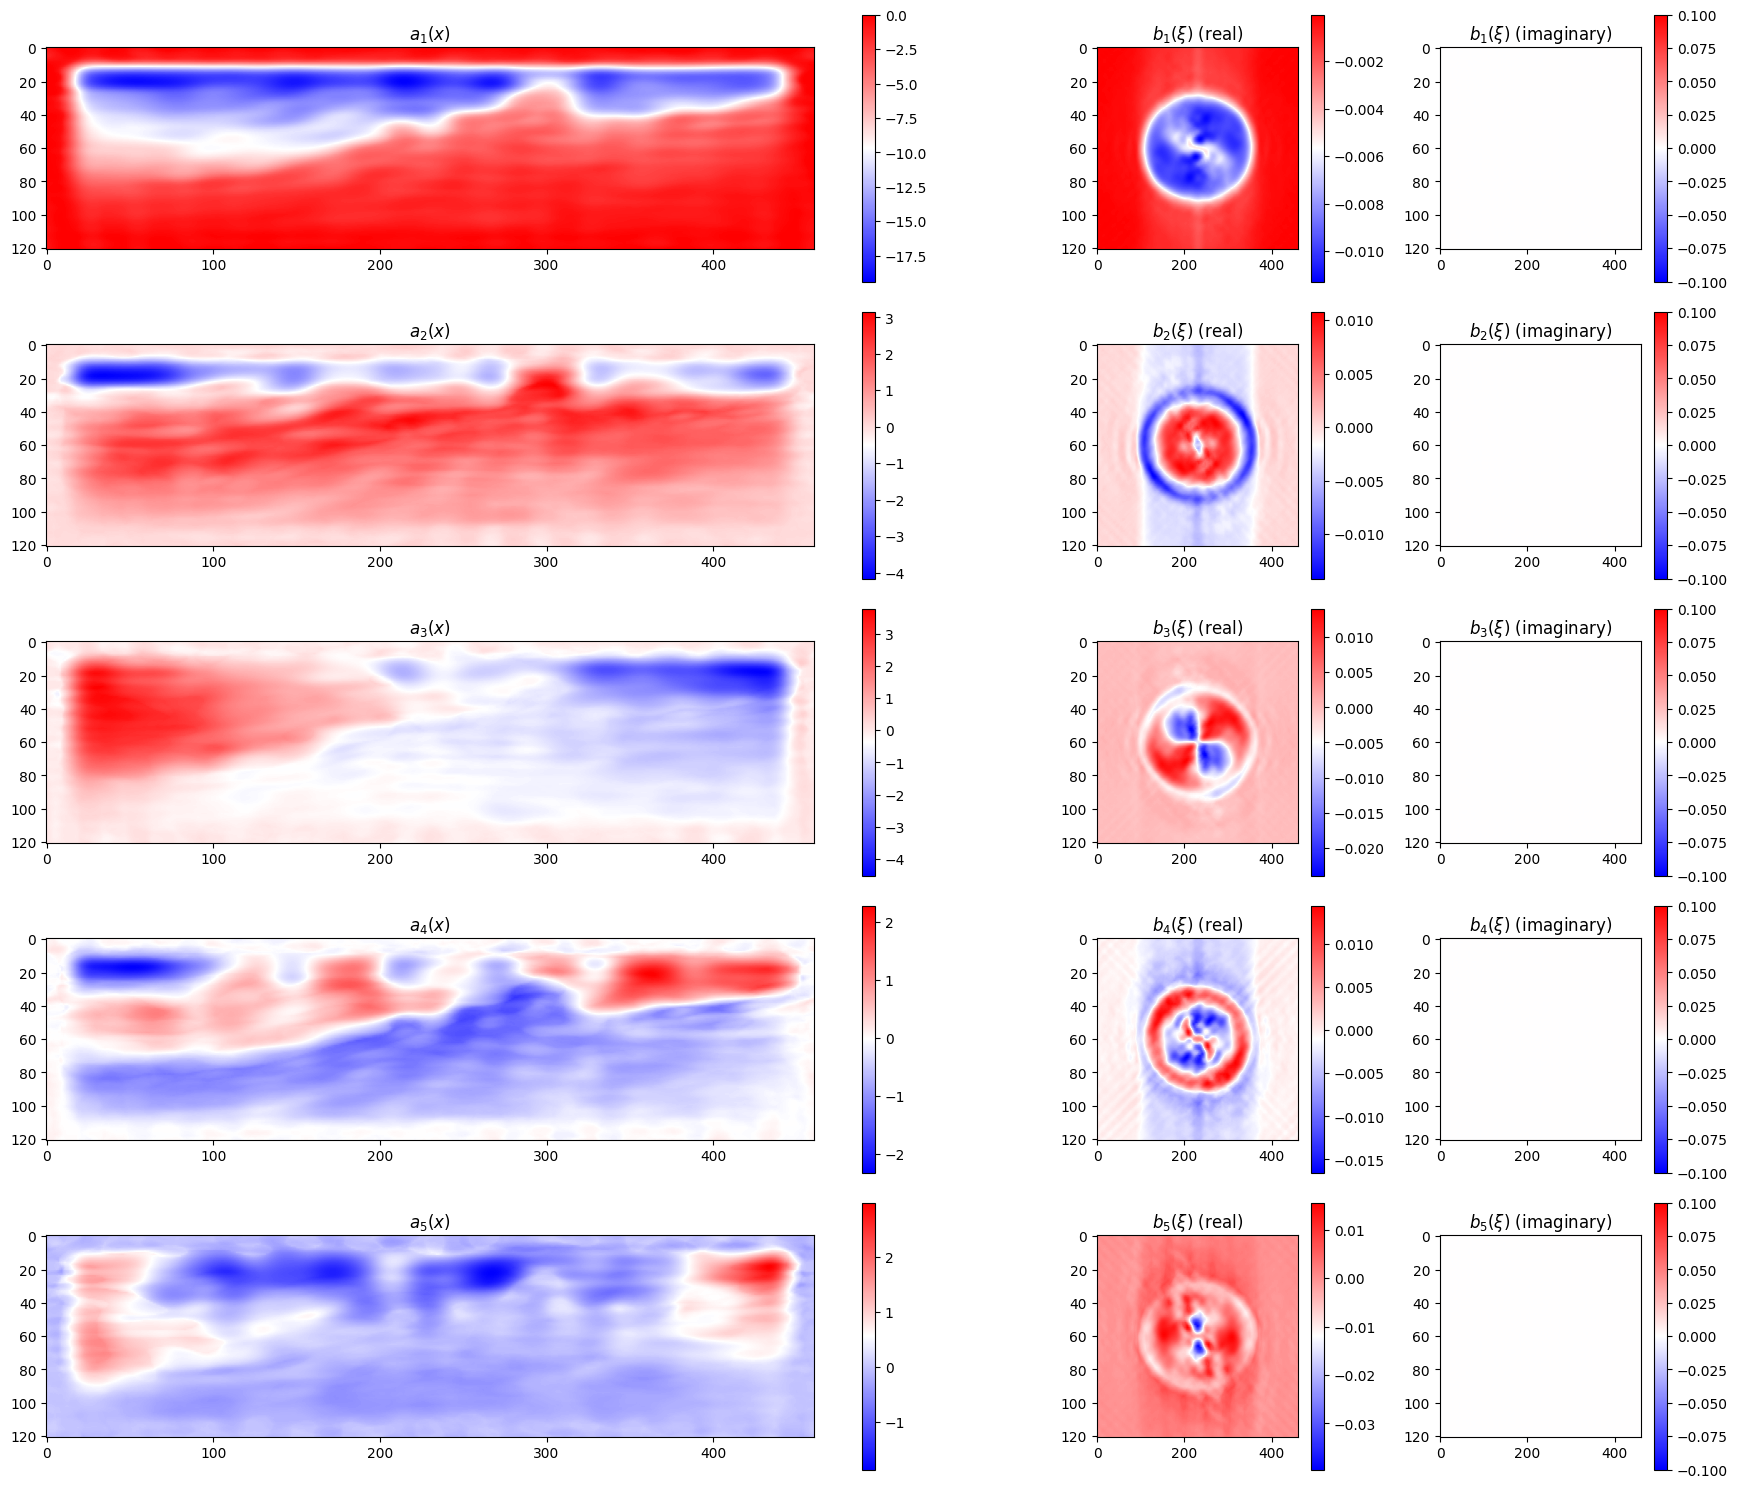

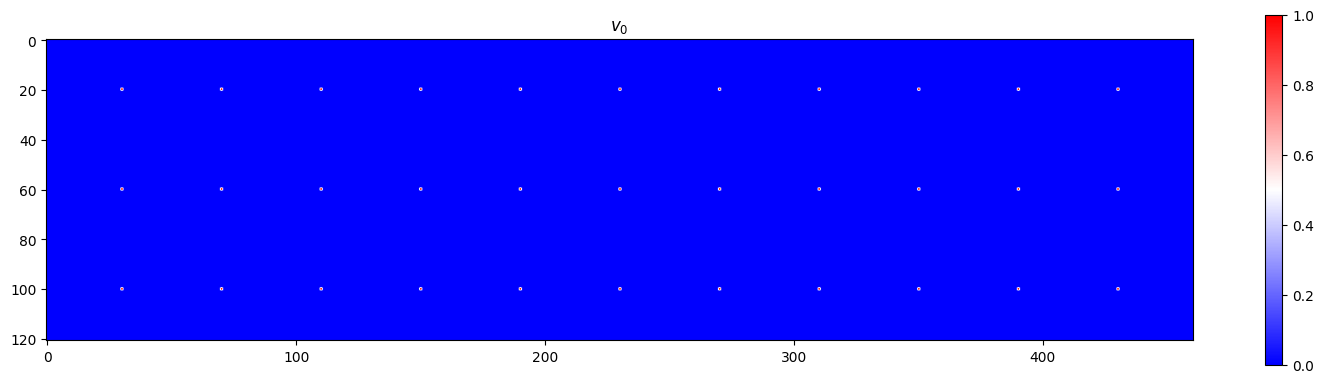

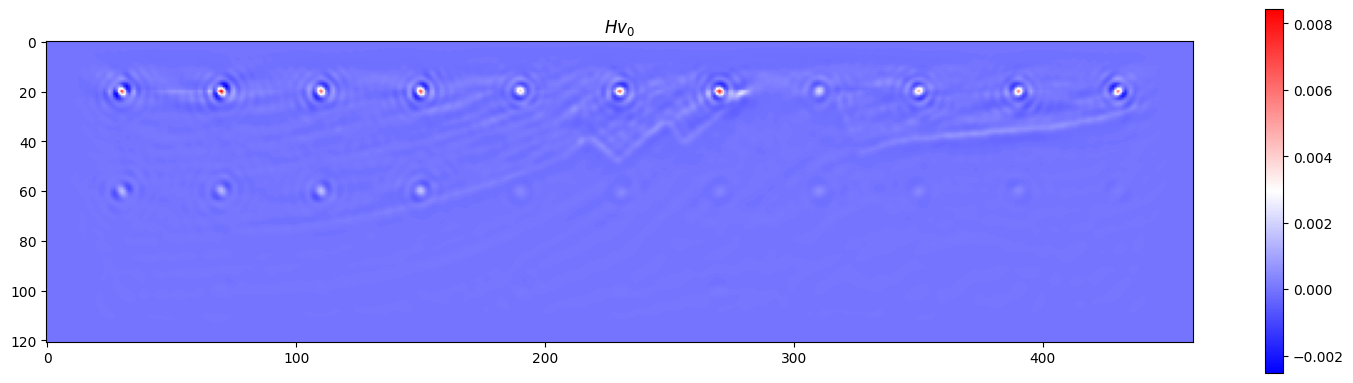

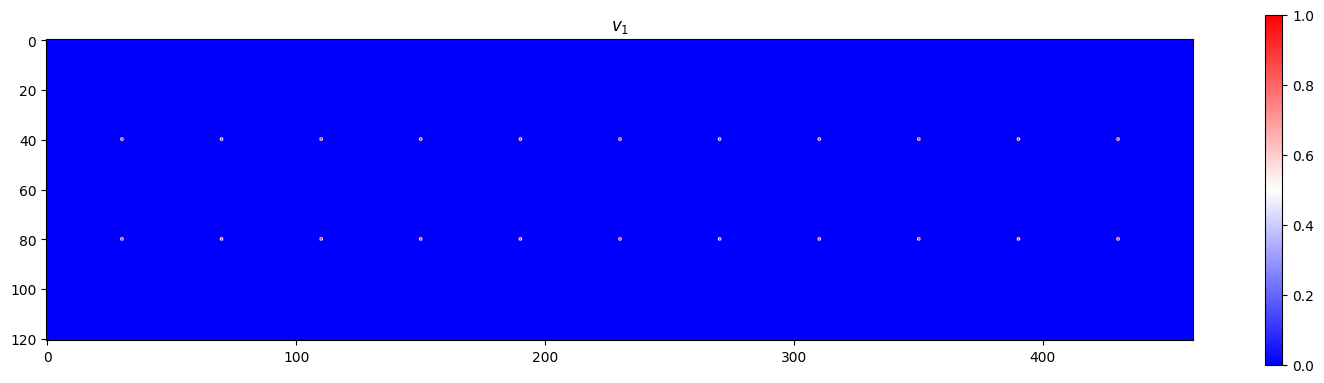

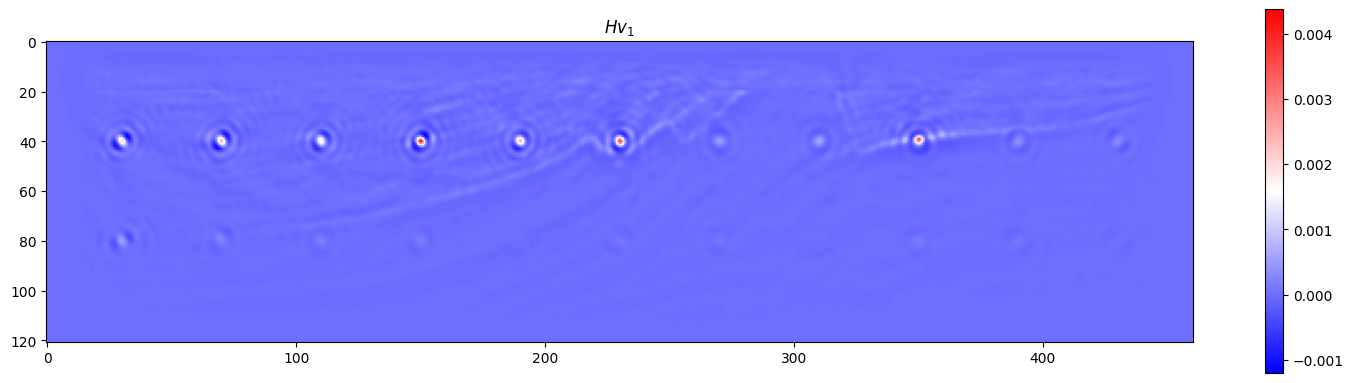

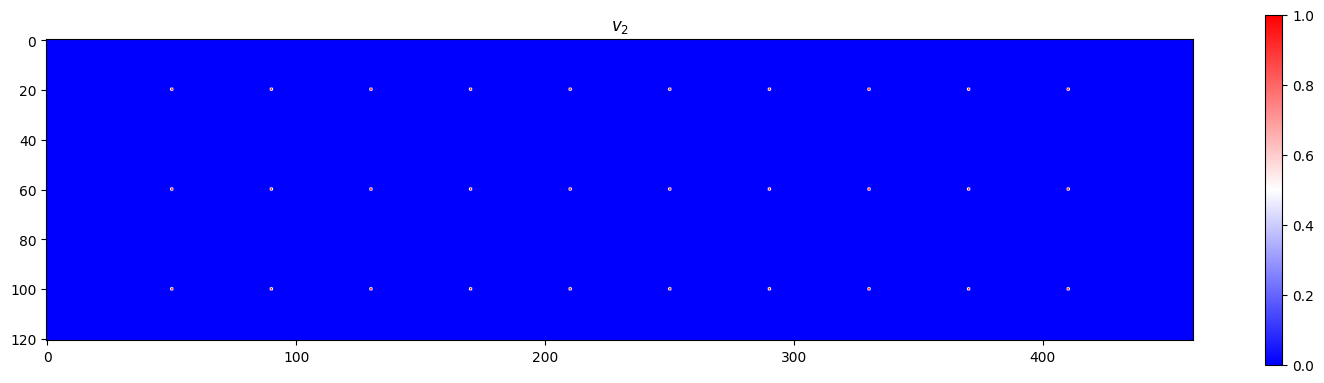

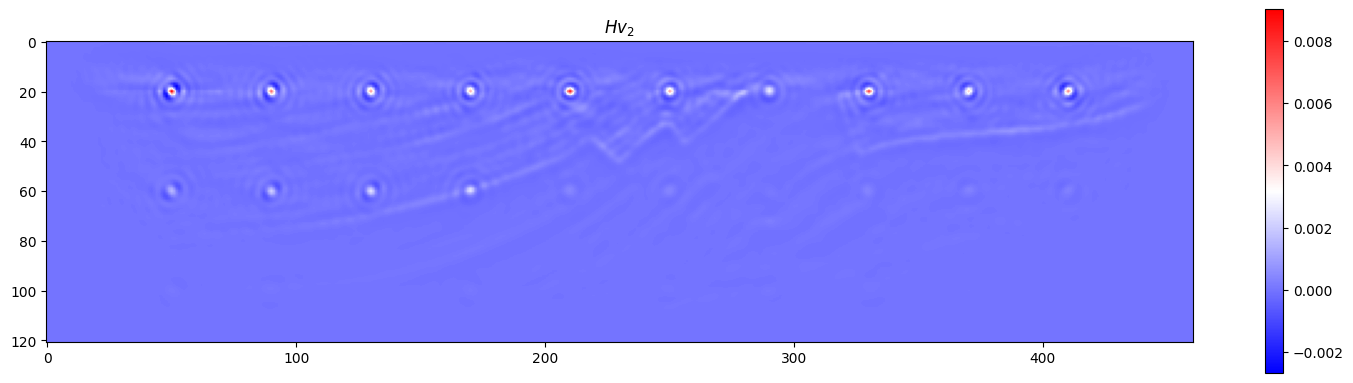

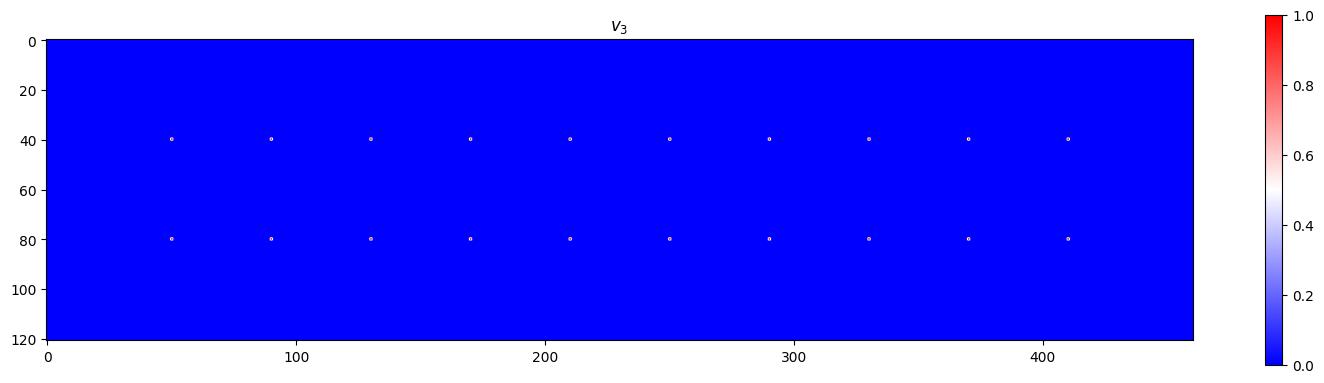

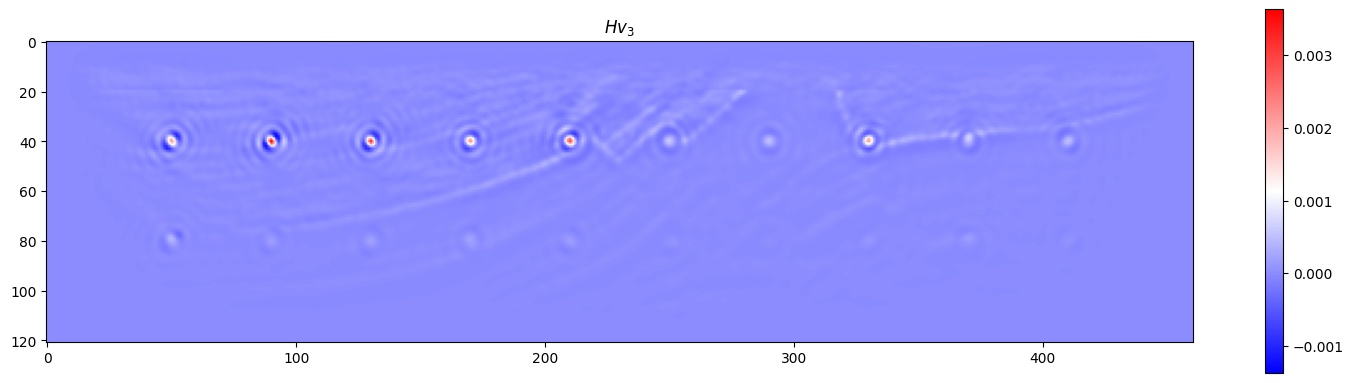

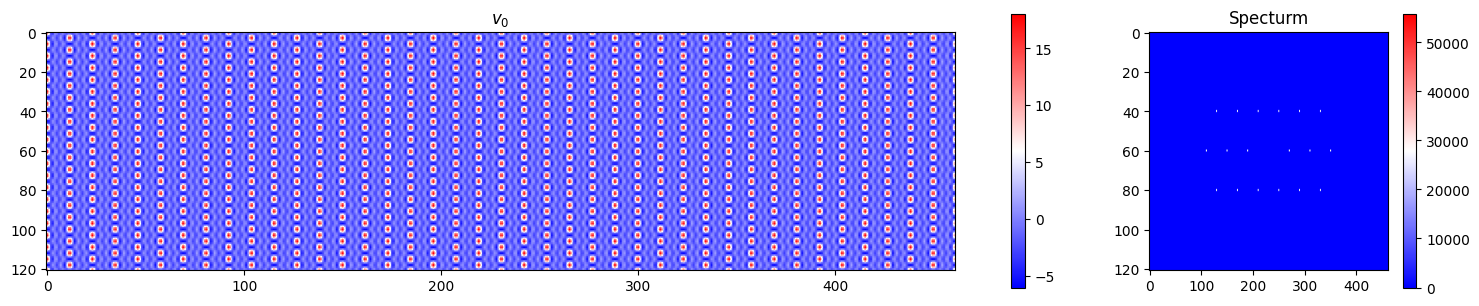

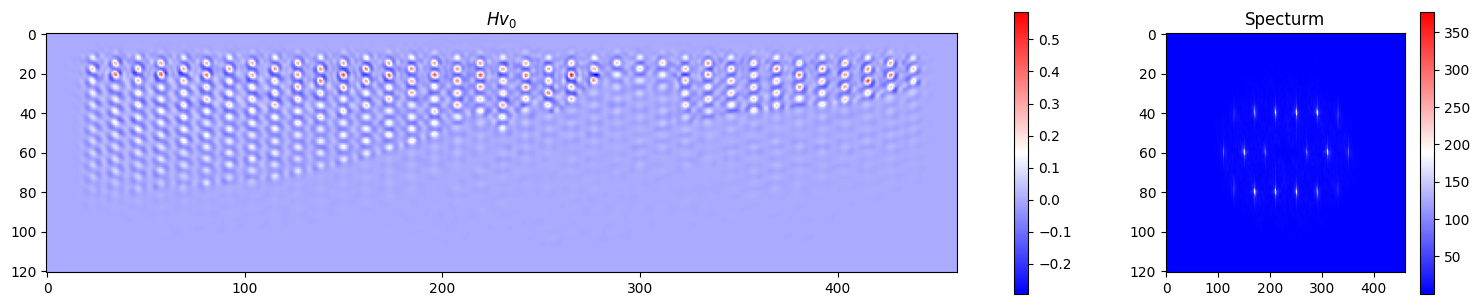

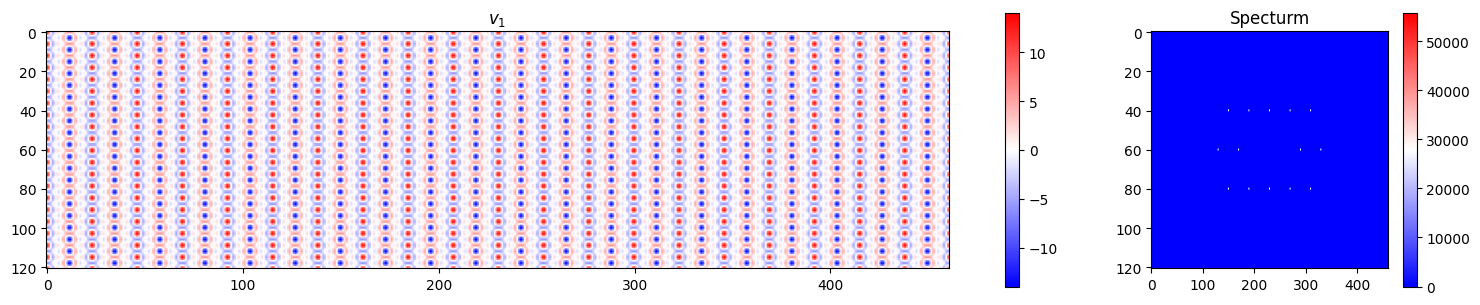

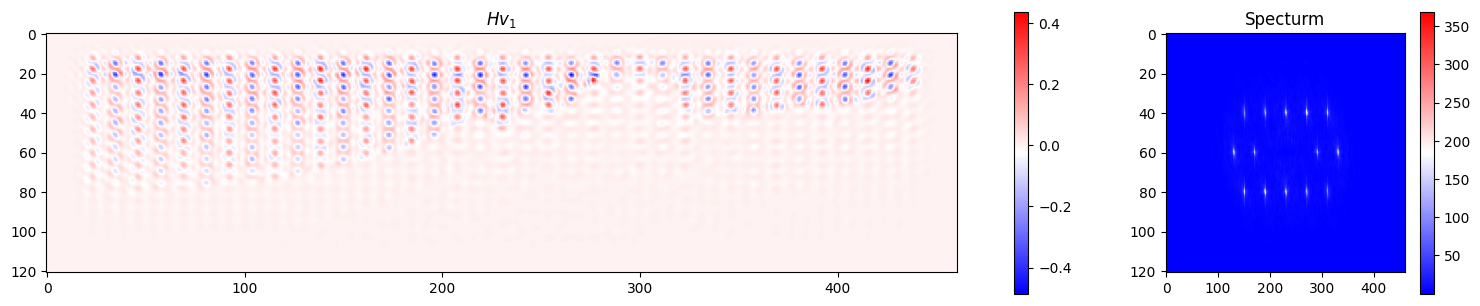

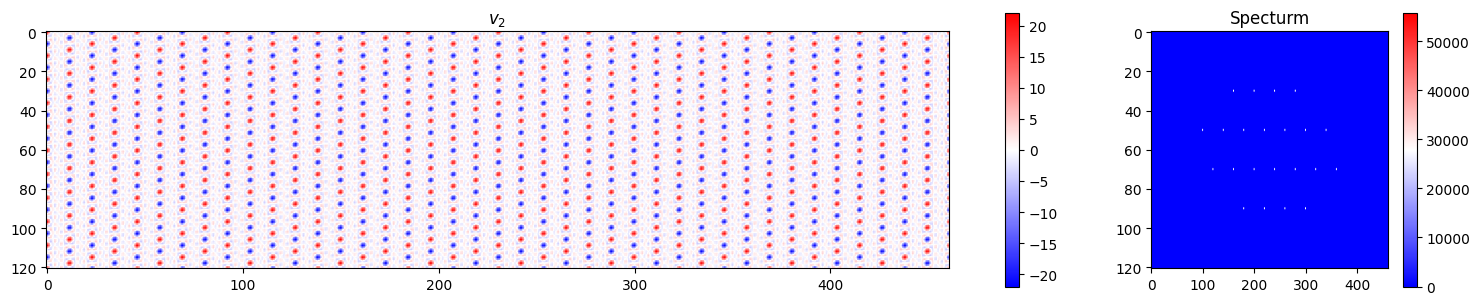

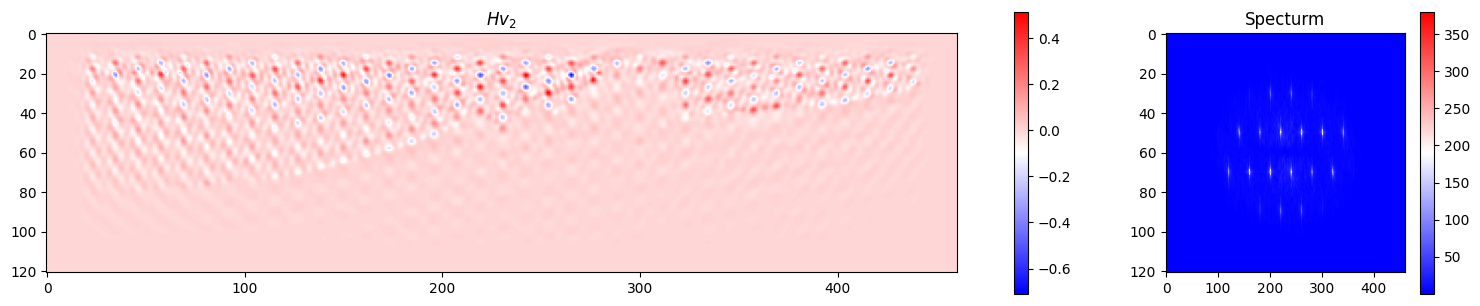

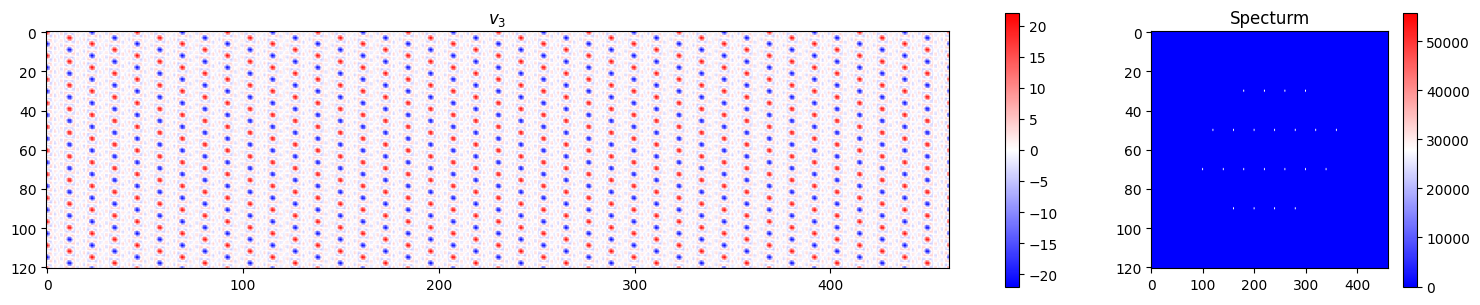

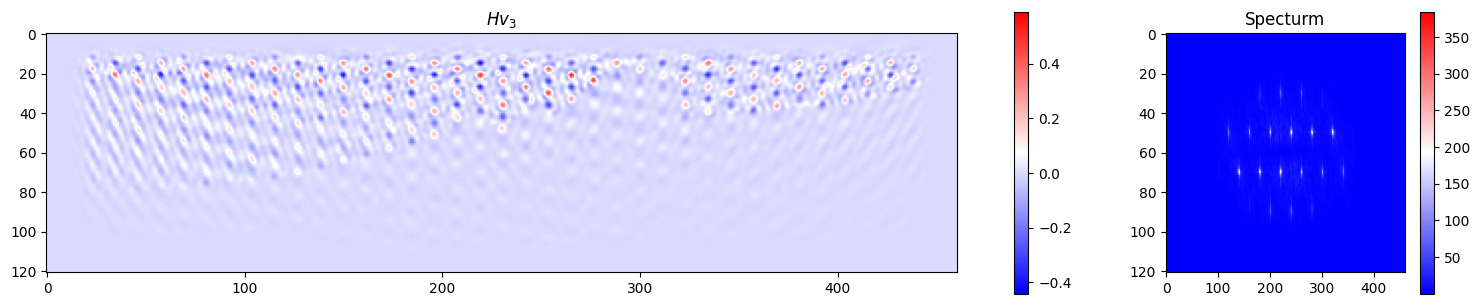

In [4]:
from lrs_psido.approximators import PsfPlusApproximator

psfp_settings = {
    "filter_sigma": 4.0,
    "matvec_plan_rows": [
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 40],
                "anchor": [30, 20],
                "constraint": {"x": [30, 430], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 40],
                "anchor": [30, 40],
                "constraint": {"x": [30, 430], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 40],
                "anchor": [50, 20],
                "constraint": {"x": [30, 430], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "equispace",
                "steps": [40, 40],
                "anchor": [50, 40],
                "constraint": {"x": [30, 430], "y": [20, 100]},
                "smoothness": 0.4,
            }
        },
    ],
    "matvec_plan_cols": [
        {
            "sampling": {
                "method": "diamond",
                "steps": [20, 20],
                "anchor": [0, 0],
                "constraint": {"l2_ratio": [0.1, 0.6]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "diamond",
                "steps": [20, 20],
                "anchor": [20, 0],
                "constraint": {"l2_ratio": [0.1, 0.6]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "diamond",
                "steps": [20, 20],
                "anchor": [10, 10],
                "constraint": {"l2_ratio": [0.1, 0.6]},
                "smoothness": 0.4,
            }
        },
        {
            "sampling": {
                "method": "diamond",
                "steps": [20, 20],
                "anchor": [10, -10],
                "constraint": {"l2_ratio": [0.1, 0.6]},
                "smoothness": 0.4,
            }
        },
    ],
    "smooth_rows": False,
    "smooth_cols": False,
    "real_only": True,
    "sqrt": True,
    "rescale": False,
    "symbol_rank": 5,
    "filter_mode": "right",
}
psfp_approximator = PsfPlusApproximator(
    sip.n,
    log_dir=EXP_PATH / "psfp",
    window=sip.window,
    show_proc=False,
    **psfp_settings
)
psfp_sqrtH = psfp_approximator.approximate_sqrt(H)

## Uncertainty Quantification: MCMC with gpCN

In [4]:
# Freeze the water layer on top. (Prior is only defined on the known region)
from utils.problems import FixWaterSesimicInverseProblemWithJuliaWaveSimulation

sip2 = FixWaterSesimicInverseProblemWithJuliaWaveSimulation(
    Lx=9200.0,
    Ly=2000.0,
    nx=461,
    ny=101,
    nw=20,  # grids of fixed top
    cmin=1500.0,
    cmax=4000.0,
    smooth_sigma=6,
    mt=np.load("mt.npy")[:, 20:],
    fmin=4.0,
    fmax=10.0,
    n_src=92,
    n_rcv=153,
    T=8.0,
    nt=4001,
    window_config={
        "left": 30,
        "right": 30,
        "up": 20,
        "down": 20,
        "ex": 3.0,
        "ll": 2.0,
    },
    prior_config={"name": "bilaplacian", "sigma2": 300.0},
    noise_variance=0.01,
    plot_config={
        "rcParams": {
            "image.cmap": "bwr",
        },
        "x_size": [7, 2],
        "f_size": [2.4, 2],
    },
    label="marmousi",
    path=EXP_PATH,
    client=client,
)
Z = sip2.Z

In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as spla
from uq.mcmc import MCMC, FullTracerSmallMemory, GaussianPrior, pCNKernel, gpCNKernel
from utils.lowrank import LowRankOperator, LowRankSqrtInvOperator
from utils.randomized_eigs import randomized_eigs
from utils.matrix_function_lanczos import InvSqrtLinearOperator

xf = np.load("xf.npy")


def run_pcn(
    sip: SeismicInverseProblem, nsamples: int, update_rate: float, out_path: Path
) -> None:
    out_path.mkdir(parents=True, exist_ok=True)

    # prior
    nu = GaussianPrior(
        R=sip.prior.R,
        sqrtRinv=sip.sqrtRinv,
        mean=sip.prior.mean,
    )

    # Set up MCMC
    tracer = FullTracerSmallMemory(nsamples, sip.N, 100, out_path)
    kernel = pCNKernel(sip.misfit_cost, nu, s=update_rate)
    chain = MCMC(kernel, nsamples, ncheck=100)

    # Draw samples
    np.random.seed(42)  # Reproducible
    if tracer.i == 0:  # New start
        naccept = chain.run(xf, tracer=tracer)
    else:  # Resume
        x_start = tracer.load(tracer.i - 1)
        chain.consume_random(chain.nburnin + tracer.i)
        naccept = chain.resume(x_start, tracer.i, tracer=tracer)
    print(f"number of acceptance = {naccept}/{nsamples}", flush=True)


def compute_eigs(
    sip: SeismicInverseProblem,
    approx_H: spla.LinearOperator,
    rank: int,
    oversampling: int,
) -> tuple[np.ndarray, np.ndarray]:
    H = sip.misfit_hess(xf)
    approx_H = approx_H
    approx_HR = approx_H + sip.R
    approx_HRinv = spla.LinearOperator(
        shape=(sip.N, sip.N),
        dtype=float,
        matvec=lambda x: spla.cg(approx_HR, x, rtol=1e-15)[0],
        rmatvec=lambda x: spla.cg(approx_HR, x, rtol=1e-15)[0],
    )
    d, U = randomized_eigs(H - approx_H, approx_HR, approx_HRinv, rank, oversampling)
    return d, U


def run_gpcn(
    sip: SeismicInverseProblem,
    approx_H: spla.LinearOperator,
    d: np.ndarray,  # eigenvalues
    U: np.ndarray,  # eigenvectors
    nsamples: int,
    update_rate: float,
    out_path: Path,
) -> None:
    out_path = Path(out_path)
    out_path.mkdir(parents=True, exist_ok=True)

    if approx_H is None:
        approx_H = spla.aslinearoperator(np.zeros((sip.N, sip.N)))
    approx_HR = approx_H + sip.R
    approx_HRinv = spla.LinearOperator(
        shape=(sip.N, sip.N),
        dtype=float,
        matvec=lambda x: spla.cg(approx_HR, x, rtol=1e-15)[0],
        rmatvec=lambda x: spla.cg(approx_HR, x, rtol=1e-15)[0],
    )
    approx_sqrtHRinv = InvSqrtLinearOperator(approx_HR, 200)

    # Low-rank correction
    approx_HR = LowRankOperator(d, U, approx_H)
    approx_sqrtHRinv = LowRankSqrtInvOperator(d, U, approx_H, approx_sqrtHRinv)

    # Laplace approximation to the posterior
    nu = GaussianPrior(
        R=approx_HR,
        sqrtRinv=approx_sqrtHRinv,
        mean=xf,
    )

    # Set up MCMC
    tracer = FullTracerSmallMemory(nsamples, sip.N, 100, out_path)
    kernel = gpCNKernel(sip.total_cost, nu, s=update_rate)
    chain = MCMC(kernel, nsamples, ncheck=100)

    # Main run
    np.random.seed(42)  # Reproducible
    if tracer.i == 0:  # New start
        naccept = chain.run(xf, tracer=tracer)
    else:  # Resume
        x_start = tracer.load(tracer.i - 1)
        chain.consume_random(chain.nburnin + tracer.i)
        naccept = chain.resume(x_start, tracer.i, tracer=tracer)
    print(f"number of acceptance = {naccept}/{nsamples}", flush=True)

/storage/mathew/Applications/miniconda3/envs/sc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Benchmark (brute force with LR-5000)

In [ ]:
# takes days
path = EXP_PATH / "prior_precond"
path.mkdir(parents=True, exist_ok=True)
d, U = compute_eigs(sip2, None, 5000, 1000)
np.save(path / "evals5000.npy", d)
np.save(path / "evecs5000.npy", U)
run_gpcn(sip, None, d, U, 50000, 0.2, path / "benchmark")

### Prior Preconditioner (pCN)

In [ ]:
# takes days
run_pcn(sip2, 50000, 0.004, EXP_PATH / "prior_precond/pcn")

### Low-Rank Preconditioner (gpCN-LR)

In [ ]:
# takes days
path = EXP_PATH / "prior_precond"
path.mkdir(parents=True, exist_ok=True)
d, U = compute_eigs(sip2, None, 90, 10)
np.save(path / "evals.npy", d)
np.save(path / "evecs.npy", U)
run_gpcn(sip, None, d, U, 50000, 0.009, path / "gpcn")

### PSF Preconditioner (gpCN-PSF)

In [ ]:
# takes days
path = EXP_PATH / "psf"
path.mkdir(parents=True, exist_ok=True)
d, U = compute_eigs(sip2, Z.H @ psf_sqrtH @ psf_sqrtH.H @ Z, 90, 10)
np.save(path / "evals.npy", d)
np.save(path / "evecs.npy", U)
run_gpcn(sip, psf_sqrtH, d, U, 50000, 0.05, path / "gpcn")

### PDO Preconditioner (gpCN-PDO)

In [ ]:
# takes days
path = EXP_PATH / "pdo"
path.mkdir(parents=True, exist_ok=True)
d, U = compute_eigs(sip2, Z.H @ pdo_sqrtH @ pdo_sqrtH.H @ Z, 90, 10)
np.save(path / "evals.npy", d)
np.save(path / "evecs.npy", U)
run_gpcn(sip, pdo_sqrtH, d, U, 50000, 0.05, path / "gpcn")

### PSF+ Preconditioner (gpCN-PSF+)

In [ ]:
# takes days
path = EXP_PATH / "psfp"
path.mkdir(parents=True, exist_ok=True)
d, U = compute_eigs(sip2, Z.H @ psfp_sqrtH @ psfp_sqrtH.H @ Z, 90, 10)
np.save(path / "evals.npy", d)
np.save(path / "evecs.npy", U)
run_gpcn(sip, psfp_sqrtH, d, U, 50000, 0.05, path / "gpcn")

### Summary

In [6]:
from seismic_inversion.mcmc_output_pipeline import MCMCResultsAnalyzer
from uq.mcmc import FullTracer

xf = np.load("xf.npy")
labels = [
    "Benchmark",
    "pCN",
    "gpCN-LR",
    "gpCN-PSF",
    "gpCN-PDO",
    "gpCN-PSF+",
]
colors = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:brown", "tab:orange"]
paths = [
    EXP_PATH / "prior_precond/benchmark",
    EXP_PATH / "prior_precond/pcn",
    EXP_PATH / "prior_precond/gpcn",
    EXP_PATH / "psf/gpcn",
    EXP_PATH / "pdo/gpcn",
    EXP_PATH / "psfp/gpcn",
]
tracers = [FullTracer(50000, sip2.N, 100, path, True) for path in paths]
datas = [t.data for t in tracers]

qoi_points = np.array([[300, 5], [50, 20], [250, 50], [410, 70], [270, 80]])
output_dir = EXP_PATH / "mcmc"

analyzer = MCMCResultsAnalyzer(
    sip,
    datas,
    labels,
    colors,
    qoi_points,
    output_dir,
)

Load 50000 existing samples.
Load 50000 existing samples.
Load 50000 existing samples.
Load 50000 existing samples.
Load 50000 existing samples.
Load 50000 existing samples.


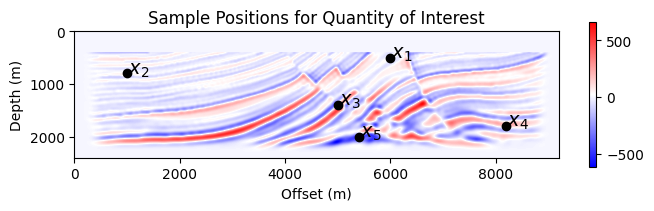

In [7]:
sip.n = np.array([461, 121])
analyzer.qoi_points = qoi_points + np.array([0, 20])
xf = np.load("xf.npy")
xf = np.hstack([np.zeros((461, 20)), xf.reshape(461, 101)])
xf = sip.W @ xf.flatten()
analyzer.plot_qoi_points(xf)

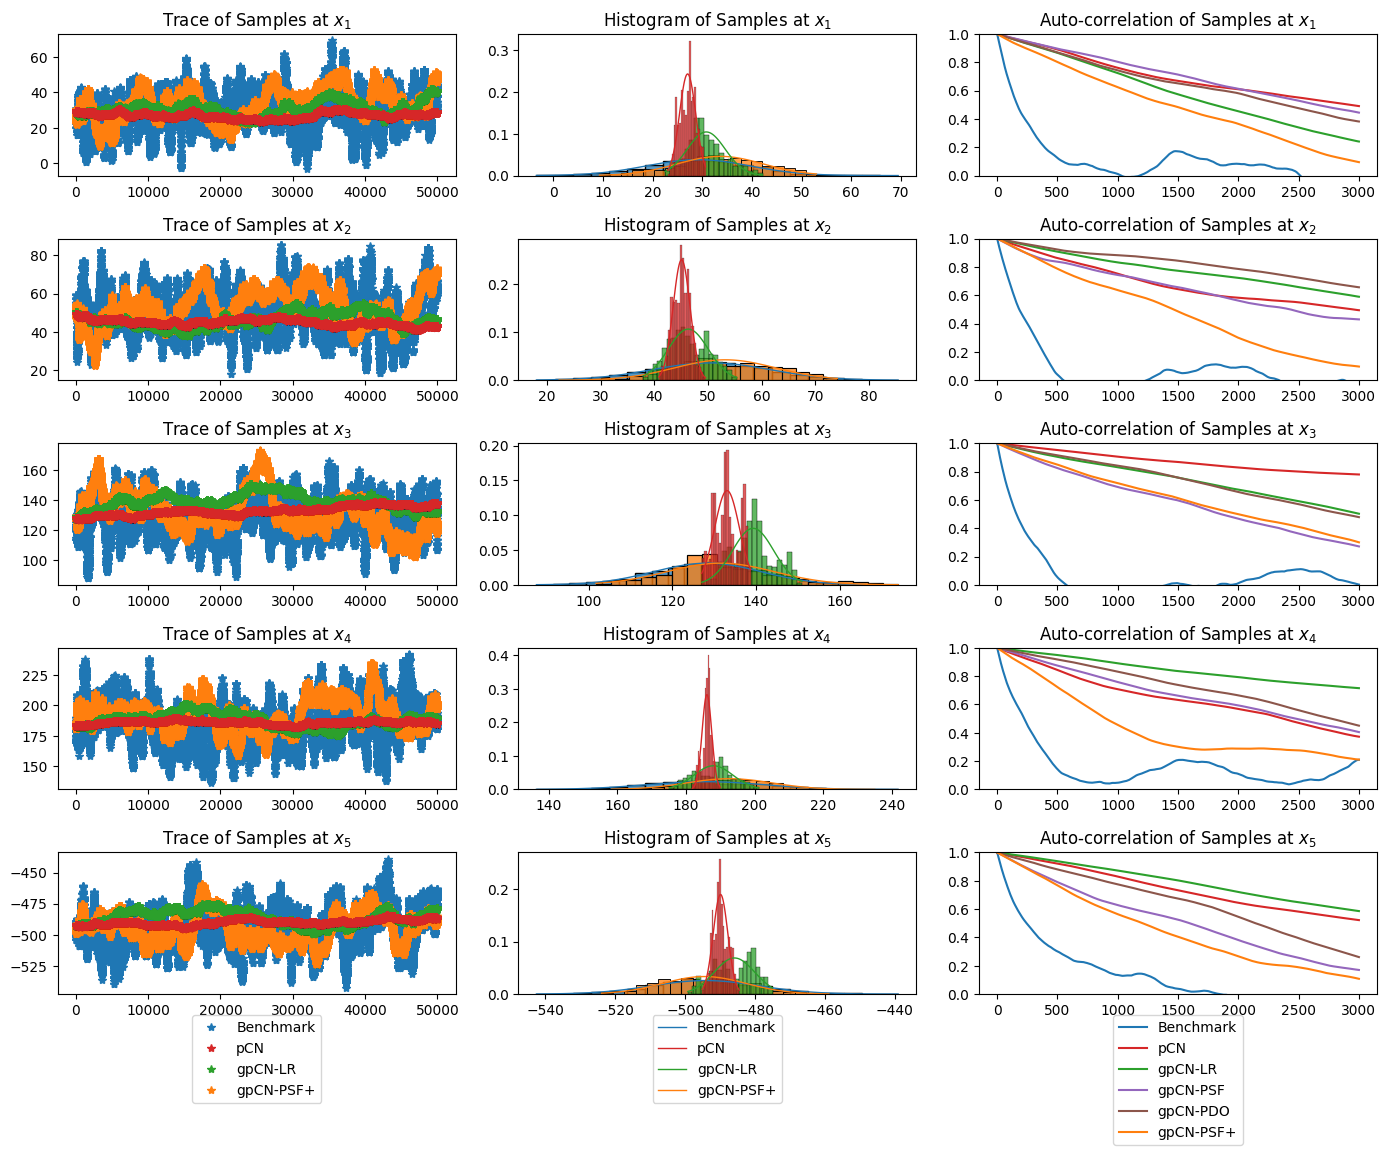

In [10]:
sip.n = np.array([461, 101])
analyzer.qoi_points = qoi_points
analyzer.plot_trace_hist_acc(selected=[0, 5, 2, 1], max_lag=3000)

In [11]:
iat = analyzer.compute_iat(max_lag=10000)
ess = 50000 / iat
print("ESS:\n", ess)

ESS:
 [[ 69.53472495 100.59486187 110.73385741  27.08094488  53.12352807]
 [  8.3010498    8.50417094   3.80176898   9.44754417   7.32569552]
 [ 12.57434923   5.3548124    8.26615601   4.78917003   5.73506619]
 [  6.72352581   6.18135732  12.84671985  10.10152261  12.32295622]
 [  9.22933951   5.0424294    7.83733806   8.94165074  12.10184696]
 [ 14.43476747  15.20757423  11.90366659  17.45822522  17.9106295 ]]


In [12]:
stds = []
for i in range(analyzer.N):
    stds.append(np.std(analyzer.datas[i], axis=0, ddof=1))

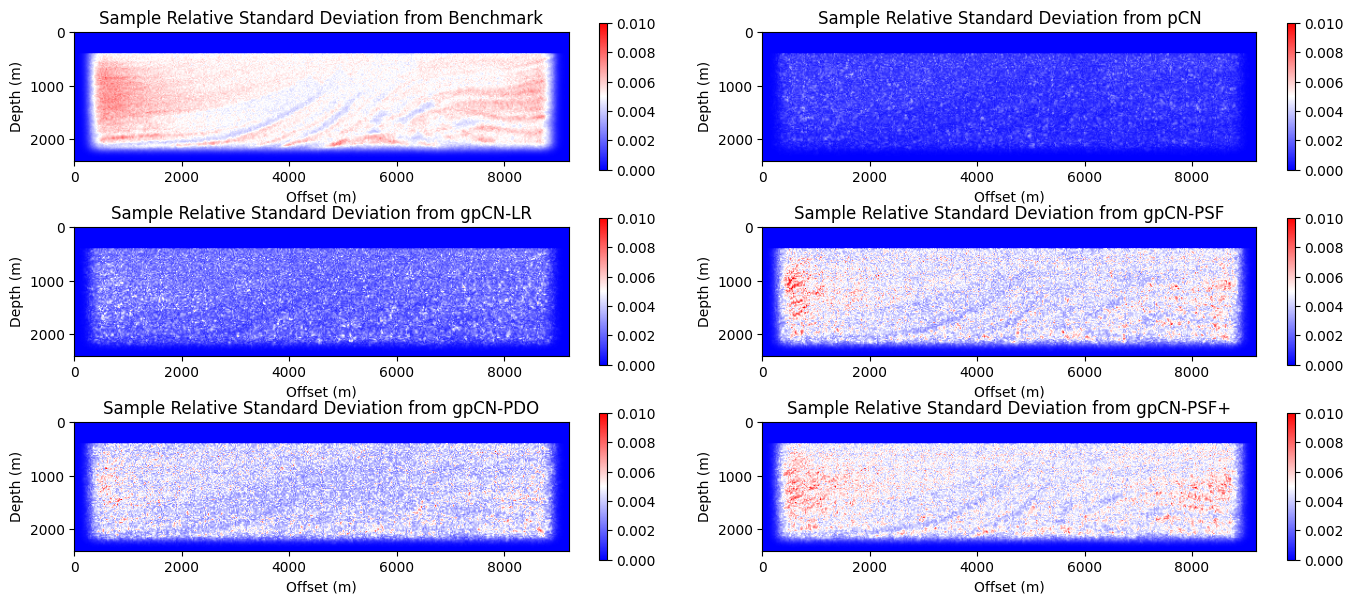

In [15]:
sip.n = np.array([461, 121])
vmin, vmax = 0.0, 0.01
m02 = np.load("m02.npy").reshape(-1)
mf2 = m02 + xf

fig, axs = plt.subplots(3, 2, figsize=(sip.x_size * (2, 3)))
for i in range(analyzer.N):
    plt.sca(axs.flat[i])
    std = np.hstack([np.zeros((461, 20)), stds[i].reshape(461, 101)]).flatten()
    sip.plot(
        sip.W @ std / mf2,
        vmin=vmin,
        vmax=vmax,
        title="Sample Relative Standard Deviation from " + analyzer.labels[i],
        colorbar=True,
    )
plt.tight_layout()